# Third Assignment

##MSc course in Artificial Intelligence

insert your "Name Surname"

In [1]:
# !rm -r AI_USI_MA/
!git clone https://github.com/UmbertoJr/AI_USI_MA.git

fatal: destination path 'AI_USI_MA' already exists and is not an empty directory.


name: eil76
nPoints: 76
best_sol: 538.0


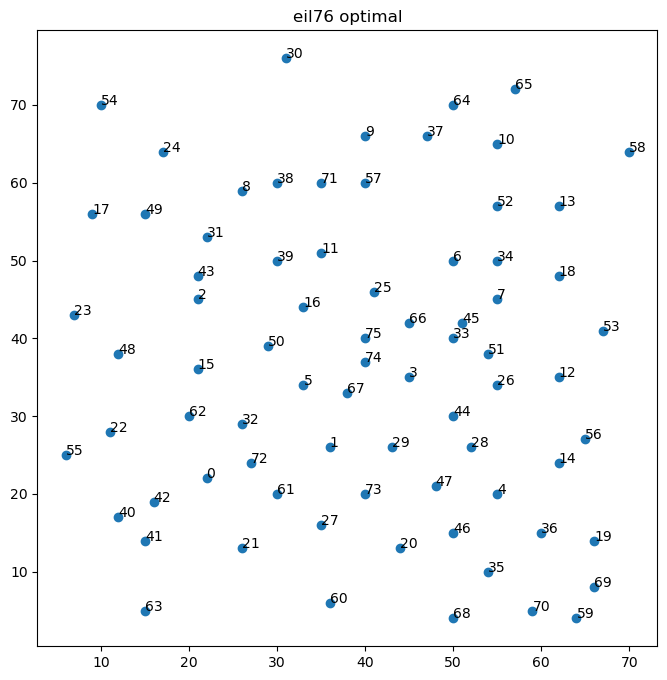

In [2]:
# Imports

from AI_USI_MA.IO_manager.io_tsp import TSP_Instance_Creator
# if you are running from your local remove the prefix AI2020 (comment the previous line and uncomment the following line)
# from IO_manager.io_tsp import TSP_Instance_Creator

from time import time

ic = TSP_Instance_Creator("standard", 'eil76.tsp')
ic.print_info()
ic.plot_data()

name: ch130
nPoints: 130
best_sol: 6110.0


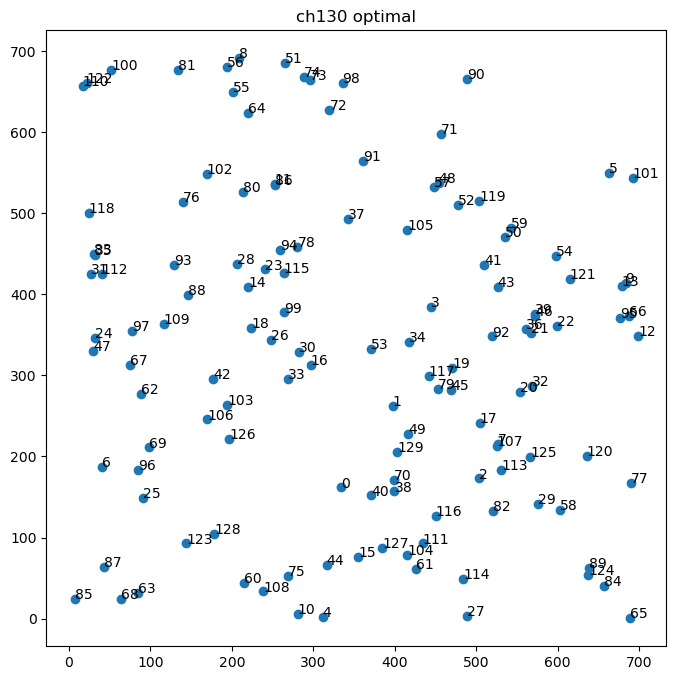

In [3]:
ic = TSP_Instance_Creator("standard", 'ch130.tsp')
ic.print_info()
ic.plot_data()

name: d198
nPoints: 198
best_sol: 15780.0


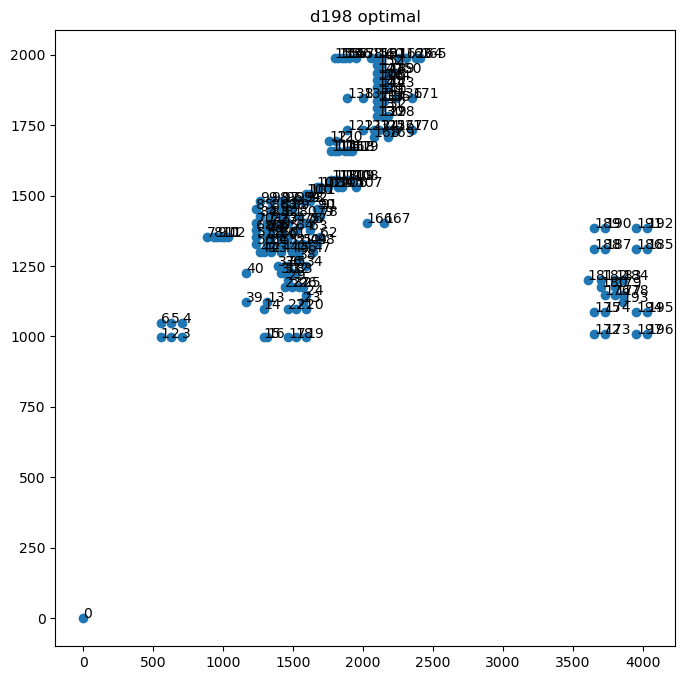

In [4]:
ic = TSP_Instance_Creator("standard", 'd198.tsp')
ic.print_info()
ic.plot_data()

name: myTSP_dim10
nPoints: 10
best_sol: 2732.0


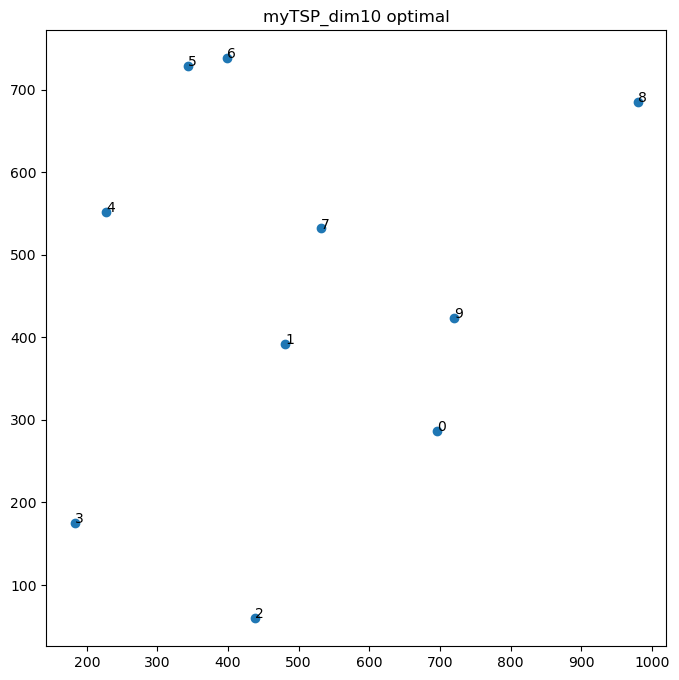

In [5]:
ic = TSP_Instance_Creator("standard", 'myTSP_dim10.tsp')
ic.print_info()
ic.plot_data()

## Ant-Colony Optimization
I have developed an Ant Colony Optimization algorithm to solve the Traveling Salesman Problem (TSP), utilising various `q0` values alongside techniques such as `ACS`, `TWO_OPT`, and `TWO_OPT_CL`. This approach permits an exhaustive investigation of the algorithm's performance under different parameter values and optimization strategies.

In [149]:
import numpy as np
from AI_USI_MA.solvers.local_search import twoOpt
from AI_USI_MA.solvers.two_opt_with_candidate import twoOpt_with_cl
from AI_USI_MA.solvers.constructive_algorithms import nn


# nn takes as input the distance matrix and returns
# the tour and the length constructed with nearest neighbor, i.e.   tour, len_t = nn(dist_mat)

# twoOpt takes as input the solution, the actual_len and the distance matrix
# and returns the tour and the length created with 2-opt, i.e.     tour, lent_t = twoOpt(solution, actual_len, dist_mat)

class ACS:
  m = 10
  beta = 2
  alpha = rho = 0.1
  cl = 20 # or 15

  @staticmethod
  def take_candidates(j, dist_mat):
    return list(np.argsort(dist_mat[j])[1:ACS.cl+1])


  def __init__(self, instance, q0, method):
    self.n = instance.nPoints
    self.dist_mat = instance.dist_matrix
    _, self.L_nn = nn(instance.dist_matrix, starting_node=np.random.choice(self.n))
    self.tau0 = 1./(float(self.n) * self.L_nn)
    
    self.position = {i: None for i in range(ACS.m)}  # position collector for the Ants, TO BE UPDATED during the steps
    self.tour = {i: [] for i in range(ACS.m)}  # tour collector for the Ants
    
    # self.pheromone = {r: [self.tau0]*ACS.cl for r in range(self.n)}
    self.candidate_list = {r: ACS.take_candidates(r, instance.dist_matrix) for r in range(self.n)}
    # self.eta = {r: [1/self.dist_mat[r, s] for s in ACS.take_candidates(r, instance.dist_matrix)] for r in range(self.n)}

    self.m = ACS.m
    
    self.jk = {i: [] for i in range(self.m)}
    
    self.visited_cities = {i: [] for i in range(self.m)}
    
    self.q0 = q0
    self.method = method
    
    self.best_cost = float('inf')
    self.best_ant = None
    self.best_tour = None
    self.best_iter = None
    
    self.iteration_np = None
    self.best_np = None
    
    self.all_costs = None
    
    self.alpha = ACS.alpha
    self.rho = ACS.rho
  
  
  def solve(self, time_limit):
    
    start_time = time()
    
    self.iteration = 0
    self.best_iter = 0
    
    self.best_cost = float('inf')
    self.best_ant = None
    self.best_tour = None
    
    self.iteration_np = None
    self.best_np = None
    
    self.iteration_np = np.array([self.iteration])
    self.best_np = np.array([self.best_cost])
    
    
    # compute pheromone matrix
    self.compute_pheromone()
    
    while (time() - start_time) < time_limit:
      # if self.iteration % 100 == 0:
        # print(f"iteration: {self.iteration}")
      
      # init tour
      self.init_tours()
      
      # # init eta
      self.compute_eta()
      
      # # create the tours
      self.build_tours()
      
      # global pheromone update
      self.global_pheromone_update()
      
      self.iteration += 1
      self.iteration_np = np.append(self.iteration_np, self.iteration)


  def compute_pheromone(self):
    pheromone = np.full((self.n,self.n), self.tau0)
    
    # print(f"pheromone matrix shape: {pheromone.shape}")
    self.pheromone = pheromone


  def init_tours(self):
    
    cities = np.arange(self.n)
    starting_cities = np.random.choice(cities, self.m, replace = False)
    
    # for each ant, create the list of cities to visit (every city except the starting one)
    for ant in range(self.m):
      s_city = starting_cities[ant]
      # self.jk[ant] = cities
      self.jk[ant] = cities[cities != s_city]

    
    # for each ant, append the starting city to the tour and update the position
    for ant in range(self.m):
      self.tour[ant].append(starting_cities[ant])
      self.position[ant] = starting_cities[ant]


  def compute_eta(self):
    
    self.eta = {r: [] for r in range(self.n)}
    for city in range(self.n):
      self.eta[city] = [1/self.dist_mat[city, s] if s != city else 0 for s in range(self.n)] 
    # print(self.eta)


  def build_tours(self):
    
    for i in range(self.n-1):
      # print(f"step: {i}\n")
      for ant in range(self.m):
        # choose the next city according to the transition rule
        next_city = self.transition_rule(ant, self.position[ant])
        # print(f"next city: {next_city}")
        
        # local pheromone update uisng a tmp variable
        local_pheromone = self.pheromone[max(self.position[ant], next_city)][min(self.position[ant], next_city)].copy()
        self.pheromone[max(self.position[ant], next_city)][min(self.position[ant], next_city)] = (1-self.rho) * local_pheromone + self.rho * self.tau0
        
        # add the next city to the tour
        self.tour[ant].append(next_city)
        
        # update the position of the ant
        self.position[ant] = next_city


  def transition_rule(self, ant, ant_position):
    
    phermone_eta = np.array(self.pheromone[ant_position]) * (np.array(self.eta[ant_position]) ** self.beta)
    
    # slice the phermone_eta array to get only the cities that are not visited yet
    phermone_eta = phermone_eta[self.jk[ant]].copy()
    
    
    # print(f"phermone_eta: {phermone_eta}")
    
    if np.random.uniform(0, 1) < self.q0:
      
      # get the index of the max value of phermone_eta
      idx = np.argmax(phermone_eta)
      
      # append the index to the visited cities
      self.visited_cities[ant].append(self.jk[ant][idx])
      
      # get the next city
      next_city = self.jk[ant][idx]
      
      # delete the city from the not visited cities
      self.jk[ant] = np.delete(self.jk[ant], idx)
      # print(f"next city: {next_city}")
      
      return next_city
    
    else:
      
      # perform the probability
      probabilities = phermone_eta / np.sum(phermone_eta)
      
      # get the index of next city
      idx = np.random.choice(range(len(probabilities)), p = probabilities)
      
      # append the index to the visited cities
      self.visited_cities[ant].append(self.jk[ant][idx])
      
      # get the next city
      next_city = self.jk[ant][idx]
      
      # delete the city from the not visited cities
      self.jk[ant] = np.delete(self.jk[ant], idx)
      # print(f"next city: {next_city}")
      return next_city


  def global_pheromone_update(self):
    
    cost = {i: [] for i in range(self.m)}
    for ant in range(self.m):
      # calculate the cost of the tour for each ant
      cost[ant] = self.compute_tour_length(self.tour[ant])
    
    # L_best
    best_cost = np.min(list(cost.values()))
    best_ant = np.argmin(list(cost.values()))
    
    # save the cost every ant
    if self.all_costs is None:
      self.all_costs = np.array([list(cost.values())])
    else:
      self.all_costs = np.append(self.all_costs, [np.array(list(cost.values()))])
    
    
    if self.method == "TWO_OPT":
      self.tour[best_ant], best_cost = twoOpt(self.tour[best_ant], best_cost, self.dist_mat)
    elif self.method == "TWO_OPT_CL":
      self.tour[best_ant], best_cost = twoOpt_with_cl(self.tour[best_ant], best_cost, self.dist_mat, self.candidate_list)
    
    edges = self.create_edges(best_ant)
    
    # keep track of the best tour, best cost and best ant
    if best_cost < self.best_cost:
      self.best_cost = best_cost
      self.best_ant = best_ant
      self.best_tour = self.tour[best_ant]
      self.best_iter = self.iteration
      # print(f"best cost: {self.best_cost} by ant {self.best_ant} with tour {self.tour[self.best_ant]} in iteration {self.best_iter}")
    
    # add the best cost to the best_np array for plotting
    self.best_np = np.append(self.best_np, self.best_cost)
    
    
    # update the global pheromone
    for i in range(len(self.tour)):
      for ant in range(self.m):
        
        # get the starting and destination city
        starting_city = max(self.tour[ant][i-1], self.tour[ant][i])
        destination_city = min(self.tour[ant][i-1], self.tour[ant][i])
        
        # tpm variable to store the pheromone of the edge (starting_city, destination_city)
        global_phermone = self.pheromone[starting_city][destination_city].copy()
        
        # if the edge (starting_city, destination city) is in the edges of the best tour, update the pheromone using the best cost, otherwise use 0
        if (starting_city, destination_city) in edges:
          self.pheromone[starting_city][destination_city] = ((1-self.alpha) * global_phermone) + (self.alpha * (1/self.best_cost))
        else:
          self.pheromone[starting_city][destination_city] = ((1-self.alpha) * global_phermone) + (self.alpha * 0)
    
    
    # reset the tour of the ants 
    self.tour = {i: [] for i in range(self.m)}
    # reset the position of the ants
    self.position = {i: None for i in range(self.m)}
    # reset the visited cities of the ants
    self.visited_cities = {i: [] for i in range(self.m)}


  # compute the cost of the tour
  def compute_tour_length(self, tour):
    
    length = 0
    for i in range(len(tour)):
      length += self.dist_mat[tour[i-1], tour[i]]
    
    return length  


  # create a list of edges for the best tour
  def create_edges(self, ant):
    
    tour = self.tour[ant]
    edges = []
    
    for i in range(len(tour)):
      starting_city = max(tour[i-1], tour[i])
      destination_city = min(tour[i-1], tour[i])
      edges.append((starting_city, destination_city))
    
    return edges


### Testing

In [150]:
import matplotlib.pyplot as plt
import numpy as np

def plot_error_results(acs, instance_best_cost, sol, ic_name, q, method, best_iters, best_tour, ic):
    
    # print the best tour found
    print(f"Best tour found: {best_tour}")
    
    # create the plot
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
    
    # compute the gaps
    gaps = (sol - instance_best_cost) / instance_best_cost
    
    # populate the plots
    axes[0].plot(gaps)
    axes[0].set_title(f"Best error: {round(min(gaps),2)} after {best_iters} tours\n for {ic_name}\n with q = {round(q,2)} and method {method}")
    axes[0].legend(["Error over iterations"])
    axes[0].set_xlabel("Iterations")
    axes[0].set_ylabel("Error")
    axes[0].grid()
    
    # order the points in the best tour
    order = ic.points[best_tour]
    order = np.append(order, [order[0]], axis=0)
    axes[1].plot(order[:,1], order[:,2], 'o-')
    
    # annotate the points
    for i, txt in enumerate(best_tour):
        axes[1].annotate(txt, (order[i, 1], order[i, 2]), textcoords="offset points", xytext=(0, 5), ha='center')
    
    # populate the plots
    axes[1].set_title(f"Best tour found\n for {ic_name}\n with q = {round(q,2)} and method {method}")
    axes[1].legend(["Best tour found"])
    axes[1].set_xlabel("x")
    axes[1].set_ylabel("y")
    axes[1].grid()
    
    plt.show()

Warning: install Prettytable `conda install -c conda-forge prettytable` or `pip install PrettyTable` or `pip3 install PrettyTable`

In [151]:
from prettytable import PrettyTable 

def print_table(ic_name, best_costs,best_iters, means, stds, best_tours, best_ants, methods, q, instance_best_cost):
    
    myTable = PrettyTable([ic_name + " " + str(round(q,2)),  "Number of tours generated" , "Best Length", "Mean Length", "Std Length", "Optimum", "Best Error"]) 
    
    # Add rows 
    for i in range(len(methods)):
        myTable.add_row([methods[i], best_iters[i], best_costs[i], round(means[i], 2), round(stds[i], 2), instance_best_cost, "{:.2f}%".format(((best_costs[i] - instance_best_cost)/instance_best_cost) * 100)])
    
    print(myTable)
    print()

In [152]:
def resulting(ic, time_limit):
  q0 = [0.5, 0.98, (1 - 13/ic.nPoints)]
  method = ["ACS", "TWO_OPT", "TWO_OPT_CL"]

  best_costs = []
  best_tours = []
  best_ants = []
  best_iters = []
  methods = []
  means = []
  stds = []

  iterations = None
  found_solutions = None


  for q in q0:
    print(f"q0: {round(q,2)}\n")
    for m in method:
      print(f"method: {m}")
      acs = ACS(ic, q0 = q, method = m)
      acs.solve(time_limit = time_limit)
      best_costs.append(acs.best_cost)
      best_tours.append(acs.best_tour)
      best_ants.append(acs.best_ant)
      methods.append(m)
      best_iters.append(acs.best_iter)
      means.append(acs.all_costs.mean())
      stds.append(acs.all_costs.std())
      if iterations is None:
        iterations = np.array(acs.iteration_np)
        found_solutions = np.array(acs.best_np)
      else:
        iterations = np.append(iterations, acs.iteration_np)
        found_solutions = np.append(found_solutions, acs.best_np)
      
      plot_error_results(acs, ic.best_sol, found_solutions, ic.name, q, m, best_iters[-1], best_tours[-1], ic)
      found_solutions = None
      iterations = None
    
    print_table(ic.name, best_costs, best_iters, means, stds, best_tours, best_ants, methods, q, ic.best_sol)
    
    best_costs = []
    best_tours = []
    best_ants = []
    methods = []
    best_iters = []
    means = []
    stds = []
    iterations = None
    found_solutions = None

## Instances

### Instance myTSP_dim10.tsp
- nPoints: 10
- best_sol: 2732.0

Instance: myTSP_dim10

q0: 0.5

method: ACS
Best tour found: [4, 3, 2, 1, 0, 9, 8, 7, 6, 5]


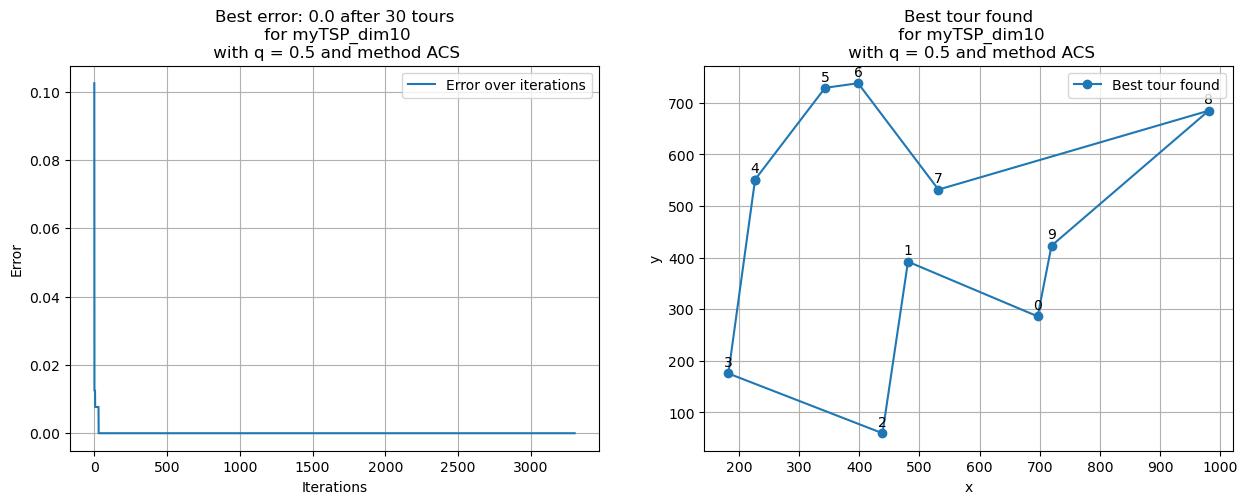

method: TWO_OPT
Best tour found: [1 0 9 8 7 6 5 4 3 2]


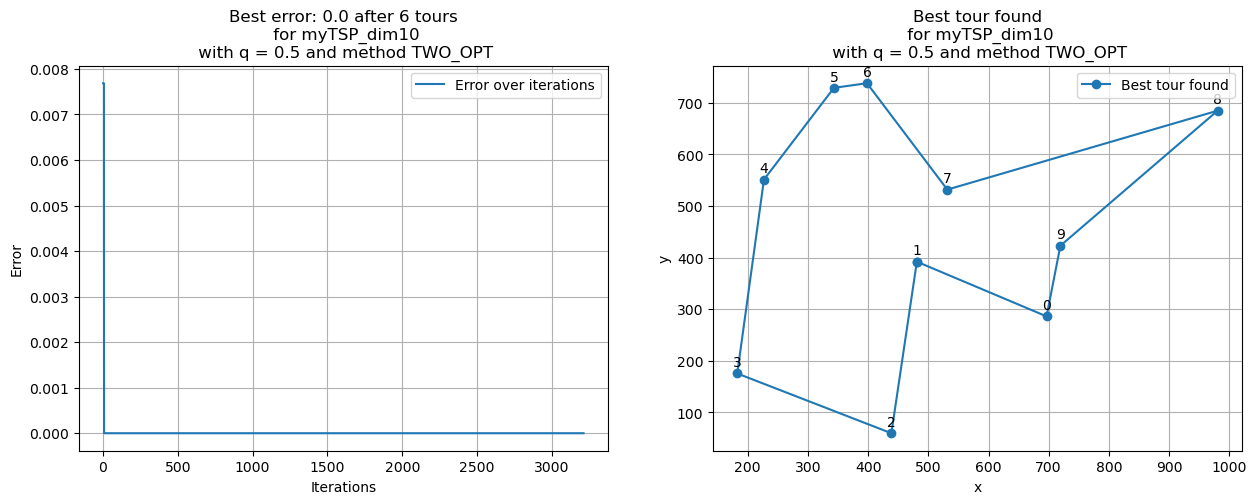

method: TWO_OPT_CL
Best tour found: [7 6 5 4 3 2 1 0 9 8]


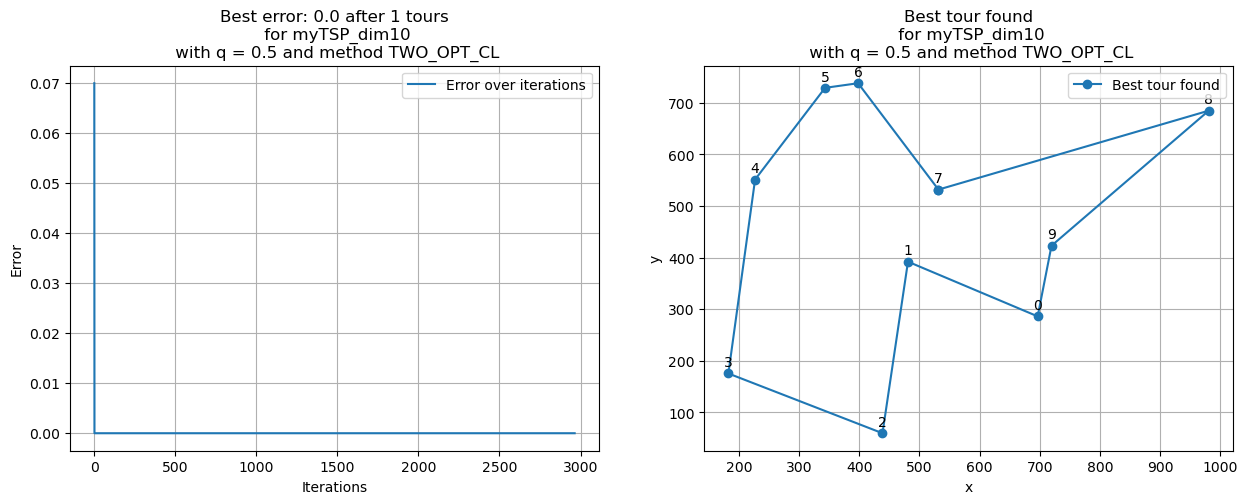

+-----------------+---------------------------+-------------+-------------+------------+---------+------------+
| myTSP_dim10 0.5 | Number of tours generated | Best Length | Mean Length | Std Length | Optimum | Best Error |
+-----------------+---------------------------+-------------+-------------+------------+---------+------------+
|       ACS       |             30            |    2732.0   |   3051.63   |   342.39   |  2732.0 |   0.00%    |
|     TWO_OPT     |             6             |    2732.0   |   3064.91   |   344.82   |  2732.0 |   0.00%    |
|    TWO_OPT_CL   |             1             |    2732.0   |   3074.54   |   348.13   |  2732.0 |   0.00%    |
+-----------------+---------------------------+-------------+-------------+------------+---------+------------+

q0: 0.98

method: ACS
Best tour found: [9, 0, 1, 2, 3, 4, 5, 6, 7, 8]


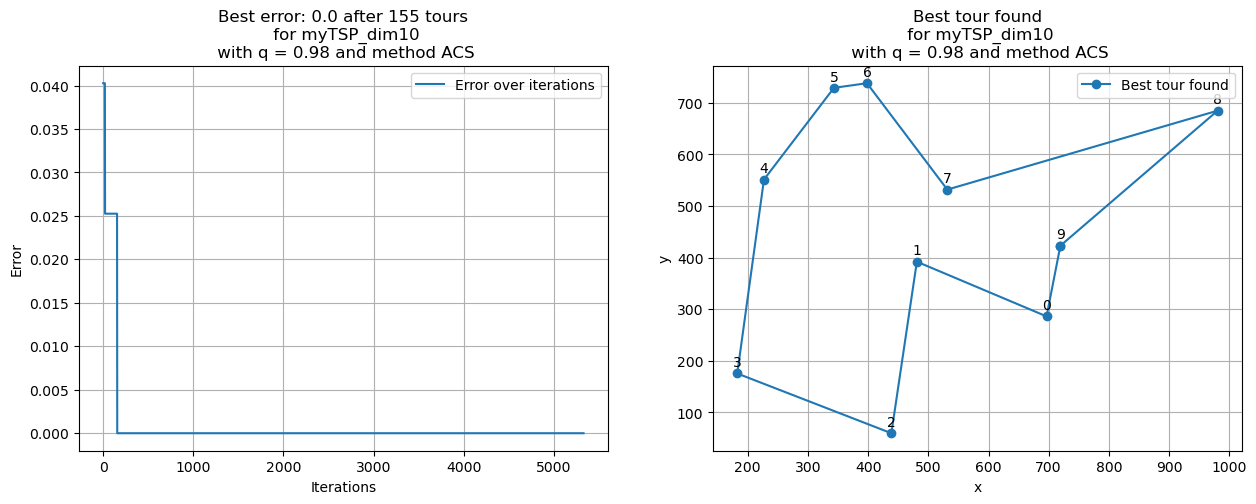

method: TWO_OPT
Best tour found: [1 0 9 8 7 6 5 4 3 2]


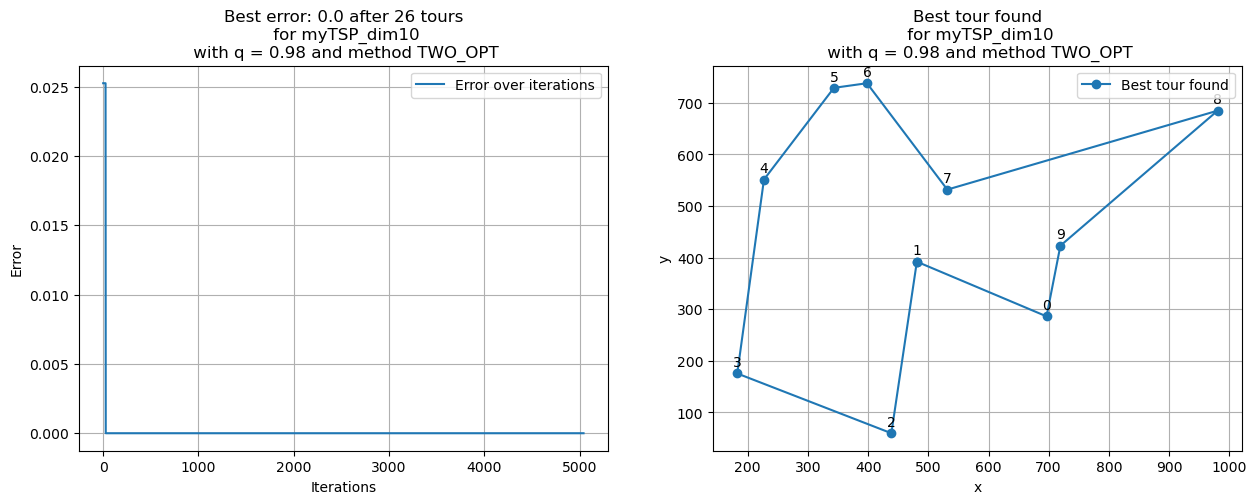

method: TWO_OPT_CL
Best tour found: [6 5 4 3 2 1 0 9 8 7]


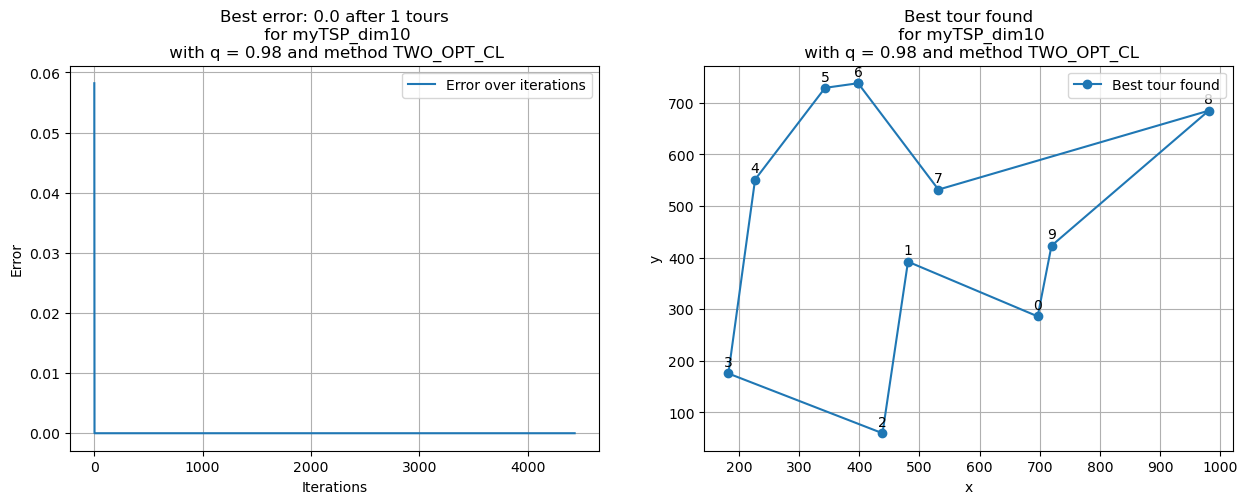

+------------------+---------------------------+-------------+-------------+------------+---------+------------+
| myTSP_dim10 0.98 | Number of tours generated | Best Length | Mean Length | Std Length | Optimum | Best Error |
+------------------+---------------------------+-------------+-------------+------------+---------+------------+
|       ACS        |            155            |    2732.0   |   2822.83   |   193.77   |  2732.0 |   0.00%    |
|     TWO_OPT      |             26            |    2732.0   |   2820.58   |   192.27   |  2732.0 |   0.00%    |
|    TWO_OPT_CL    |             1             |    2732.0   |   2817.92   |   190.68   |  2732.0 |   0.00%    |
+------------------+---------------------------+-------------+-------------+------------+---------+------------+

q0: -0.3

method: ACS
Best tour found: [6, 5, 4, 3, 2, 1, 0, 9, 8, 7]


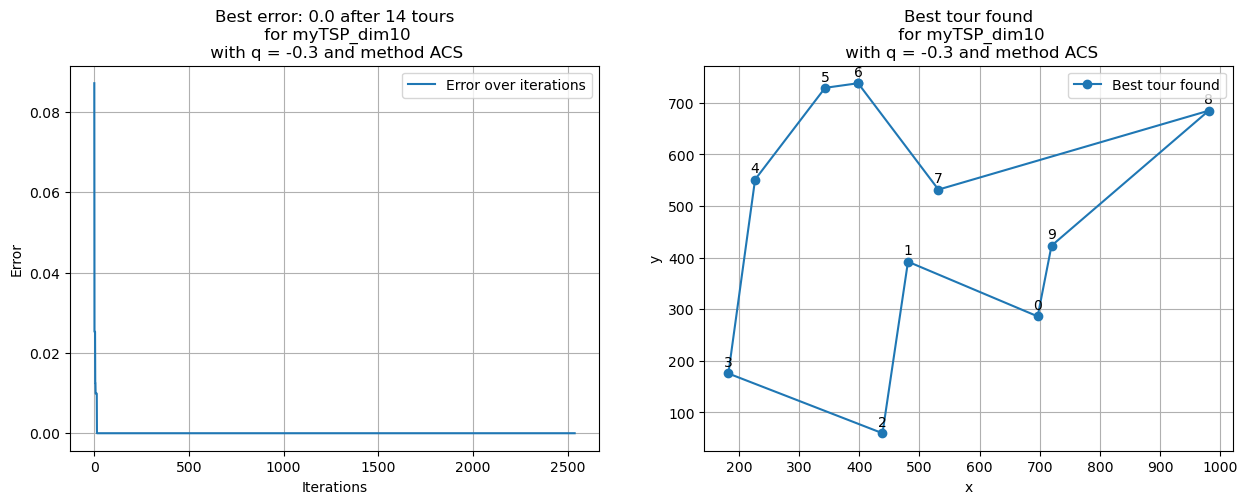

method: TWO_OPT
Best tour found: [9 8 7 6 5 4 3 2 1 0]


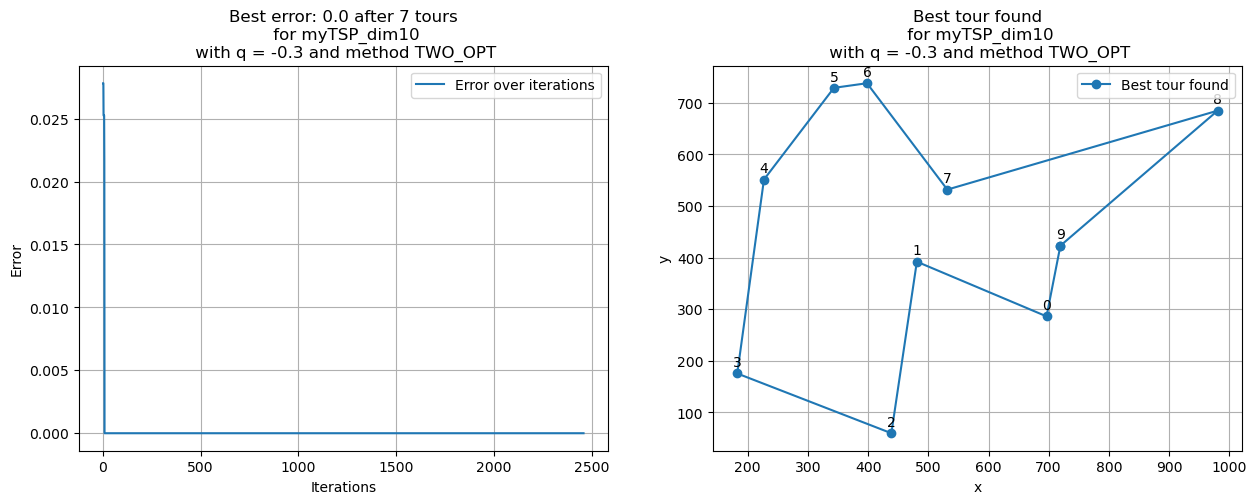

method: TWO_OPT_CL
Best tour found: [1 0 9 8 7 6 5 4 3 2]


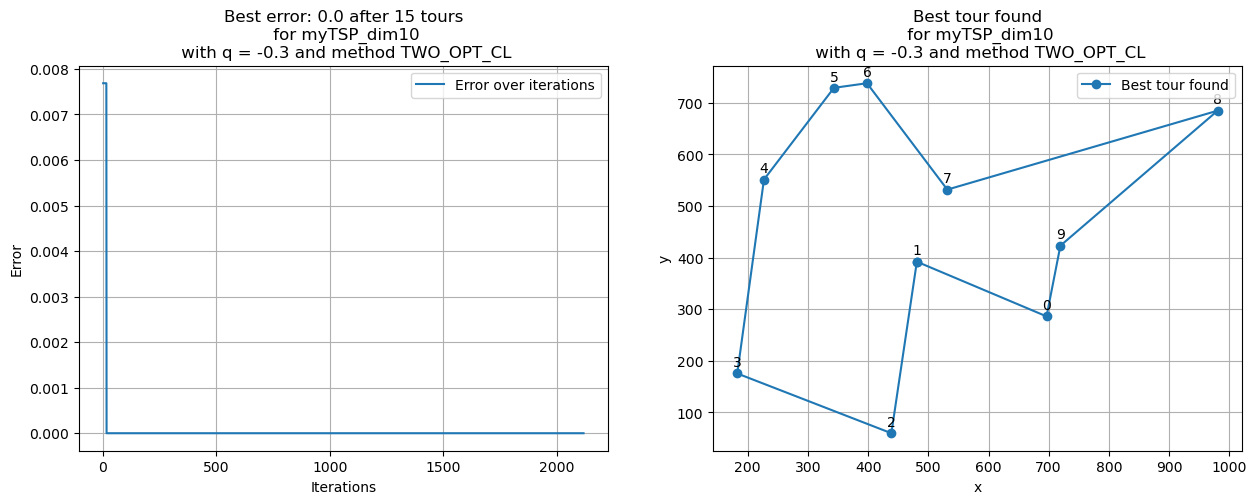

+------------------+---------------------------+-------------+-------------+------------+---------+------------+
| myTSP_dim10 -0.3 | Number of tours generated | Best Length | Mean Length | Std Length | Optimum | Best Error |
+------------------+---------------------------+-------------+-------------+------------+---------+------------+
|       ACS        |             14            |    2732.0   |   3330.65   |   364.9    |  2732.0 |   0.00%    |
|     TWO_OPT      |             7             |    2732.0   |    3297.8   |   363.56   |  2732.0 |   0.00%    |
|    TWO_OPT_CL    |             15            |    2732.0   |   3322.65   |   363.83   |  2732.0 |   0.00%    |
+------------------+---------------------------+-------------+-------------+------------+---------+------------+



In [147]:
ic = TSP_Instance_Creator("standard", 'myTSP_dim10.tsp')
print(f"Instance: {ic.name}")
print()

resulting(ic, time_limit=4)

#### Comment 
My implemented ant-colony optimization algorithm obtains the global optimum. This is confirmed by the algorithm's performance via visual representation and quantitative output. The plots illustrate the algorithm's consistent convergence towards the global optimum over iterations. Furthermore, numerical evidence from print statements confirms the achievement of the global optimum during the optimization process. As expected, since this istance is quite easy, both the `q0` value and the method (`ACS`, `TWO_OPT`, `TWO_OPT_CL`) did not influence the performance of the algorithm significantly.

------------------------------------------------------------------------------------------------------------------------------------------------------------------

### Instance eil76.tsp
- nPoints: 76
- best_sol: 538.0

Instance: eil76

q0: 0.5

method: ACS
Best tour found: [36, 19, 69, 59, 70, 35, 46, 20, 29, 1, 67, 3, 26, 12, 53, 18, 7, 34, 6, 45, 33, 51, 44, 28, 4, 14, 56, 47, 73, 27, 21, 61, 72, 0, 40, 42, 41, 55, 22, 2, 43, 25, 66, 75, 74, 5, 50, 16, 11, 71, 38, 8, 39, 31, 49, 17, 54, 24, 30, 9, 37, 10, 64, 65, 52, 13, 58, 57, 32, 62, 15, 23, 48, 63, 60, 68]


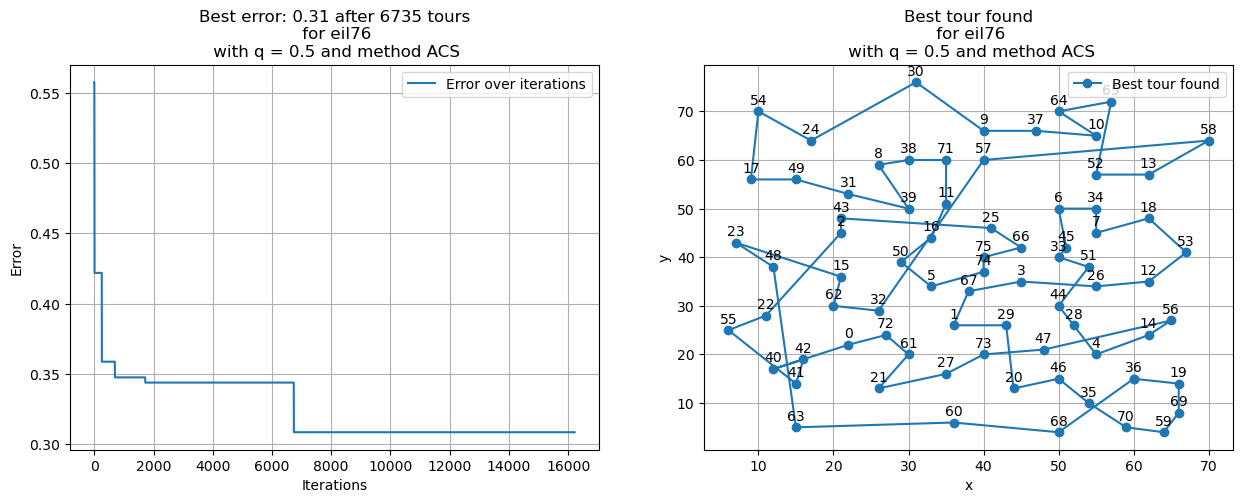

method: TWO_OPT
Best tour found: [ 7 45 33 51 26 28 44  3 66 25 75 74 67  5 50 16 11 39  2 43 31  8 38 71
 57  9 30 54 24 49 17 23 48 15 62 32 72  0 42 22 55 40 41 63 21 60 20 73
 27 61  1 29 47 46 35 68 70 59 69 19 36  4 14 56 12 53 18 13 58 65 10 64
 37 52 34  6]


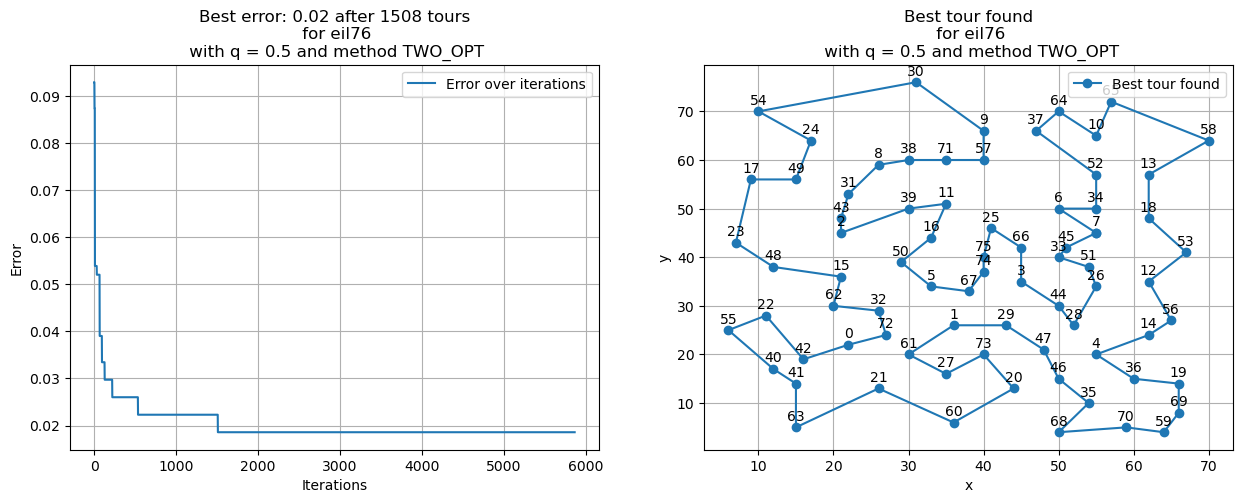

method: TWO_OPT_CL
Best tour found: [41 40 42 55 22 48 23 17 49 24 54 30  9 37 64 65 10 58 13 52 18 53 12 56
 14 44  3 26 51 33 45  7 34  6 66 25 75 74 67  5 50 16 39 11 57 71 38  8
 31 43  2 15 62 32  1 73 29 47 28  4 36 19 69 59 70 68 35 46 20 60 27 61
 72  0 21 63]


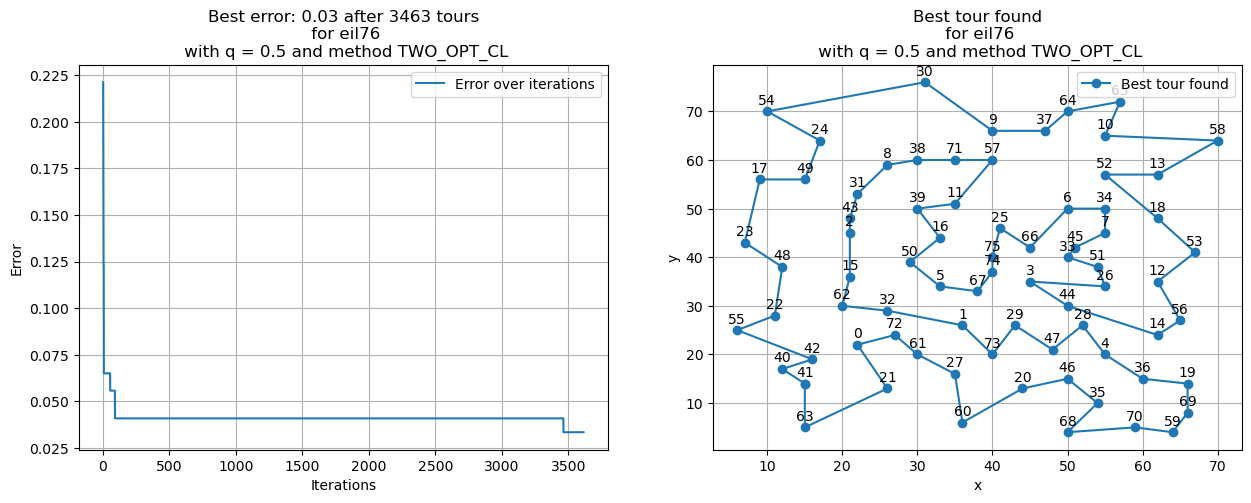

+------------+---------------------------+-------------+-------------+------------+---------+------------+
| eil76 0.5  | Number of tours generated | Best Length | Mean Length | Std Length | Optimum | Best Error |
+------------+---------------------------+-------------+-------------+------------+---------+------------+
|    ACS     |            6735           |    704.0    |   1013.21   |   85.48    |  538.0  |   30.86%   |
|  TWO_OPT   |            1508           |    548.0    |    959.69   |   82.36    |  538.0  |   1.86%    |
| TWO_OPT_CL |            3463           |    556.0    |    986.59   |   84.31    |  538.0  |   3.35%    |
+------------+---------------------------+-------------+-------------+------------+---------+------------+

q0: 0.98

method: ACS
Best tour found: [58, 10, 64, 37, 9, 57, 71, 38, 8, 31, 43, 2, 15, 62, 32, 72, 61, 27, 73, 1, 29, 47, 28, 44, 26, 51, 33, 3, 74, 67, 5, 50, 16, 39, 11, 25, 66, 75, 45, 7, 34, 6, 52, 13, 18, 53, 12, 56, 14, 4, 36, 19, 69, 59, 70,

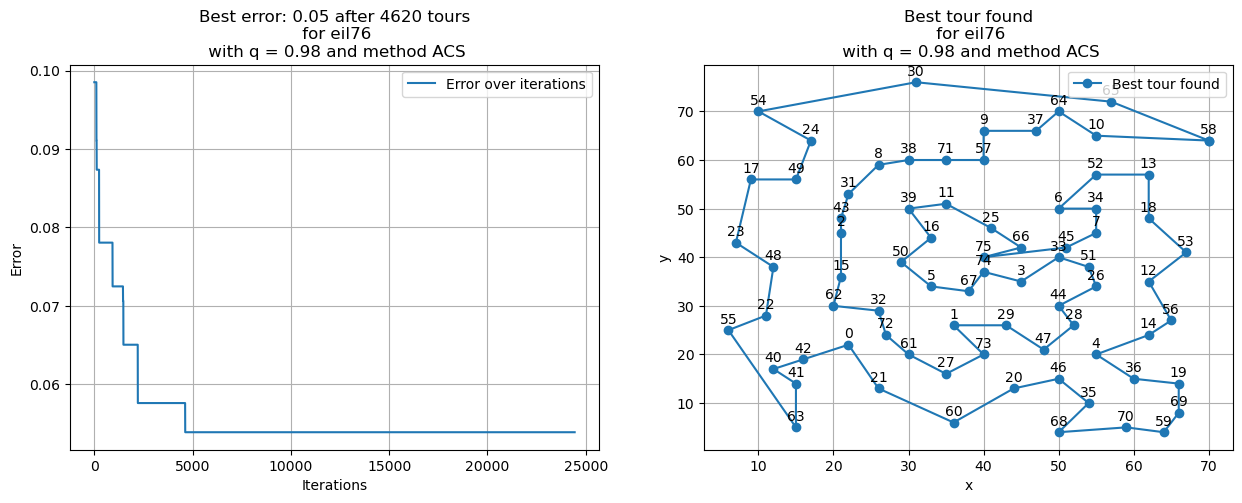

method: TWO_OPT
Best tour found: [66 25  6 34 52 13 58 65 10 64 37  9 30 54 24 49 17 23 48 22 55 40 42 41
 63 21 60 20 46 35 68 70 59 69 19 36  4 14 56 12 53 18  7 45 33 51 26 44
 28 47 29  1 73 27 61  0 72 32 62 15  2 43 31  8 38 71 57 11 39 16 50  5
 67  3 74 75]


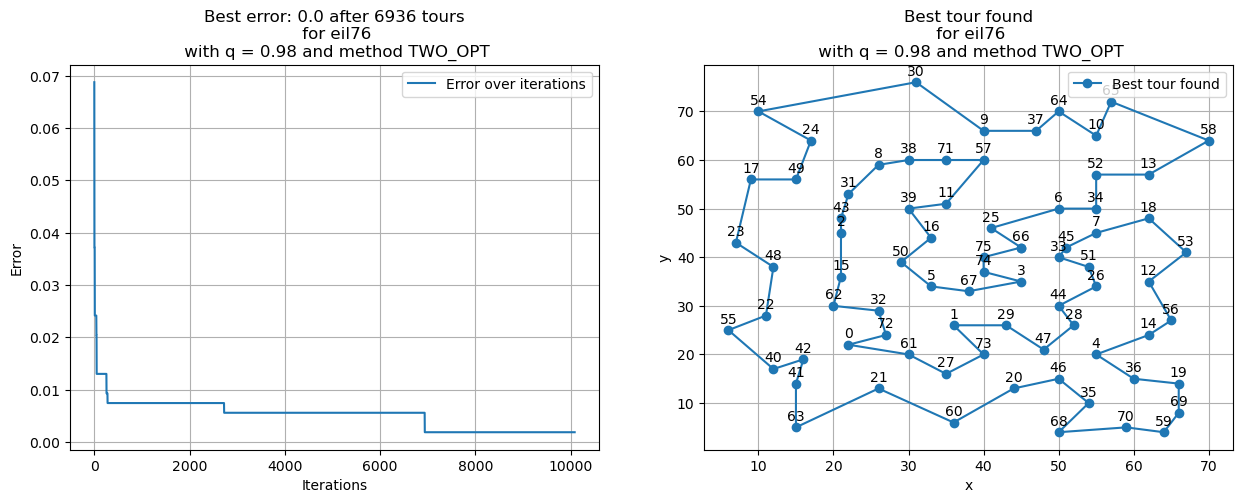

method: TWO_OPT_CL
Best tour found: [ 0 72 32 62 15  2 43 31  8 38 71 57 11 39 16 50  5 67  3 74 75 25 66 45
 33 51 26 44 28 47 29  1 73 27 61 21 60 20 46 35 68 70 59 69 19 36  4 14
 56 12 53 18  7 34  6 52 13 58 65 10 64 37  9 30 54 24 49 17 23 48 22 55
 40 42 41 63]


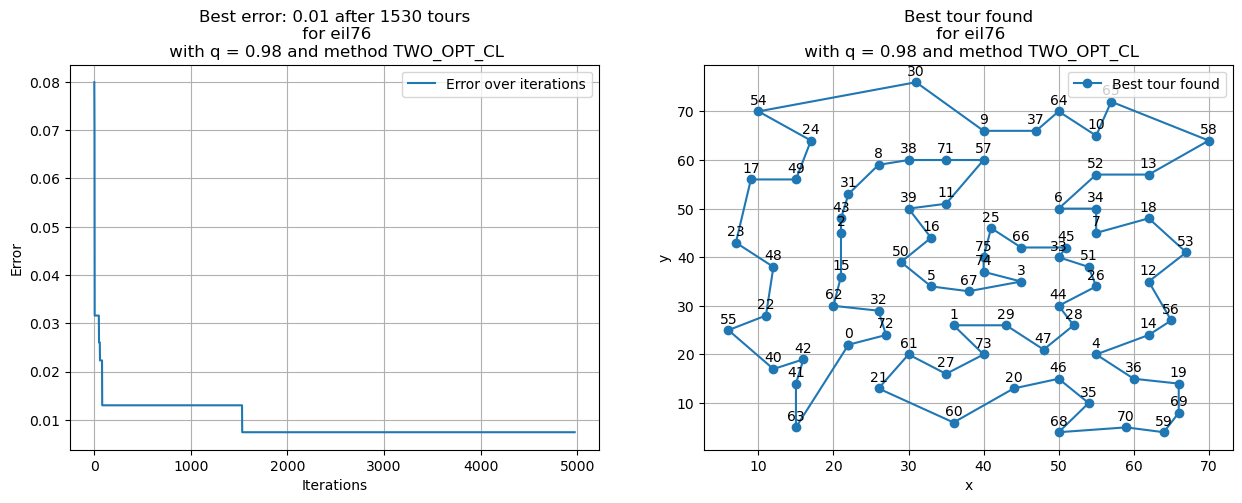

+------------+---------------------------+-------------+-------------+------------+---------+------------+
| eil76 0.98 | Number of tours generated | Best Length | Mean Length | Std Length | Optimum | Best Error |
+------------+---------------------------+-------------+-------------+------------+---------+------------+
|    ACS     |            4620           |    567.0    |    684.24   |   42.76    |  538.0  |   5.39%    |
|  TWO_OPT   |            6936           |    539.0    |    673.68   |   40.62    |  538.0  |   0.19%    |
| TWO_OPT_CL |            1530           |    542.0    |    687.8    |   44.96    |  538.0  |   0.74%    |
+------------+---------------------------+-------------+-------------+------------+---------+------------+

q0: 0.83

method: ACS
Best tour found: [50, 5, 67, 1, 29, 47, 46, 20, 73, 27, 61, 21, 0, 72, 32, 62, 15, 2, 43, 31, 8, 38, 71, 57, 9, 37, 64, 10, 65, 58, 13, 52, 34, 6, 7, 25, 66, 75, 74, 3, 33, 45, 51, 26, 12, 53, 18, 56, 14, 4, 28, 44, 36, 19, 69, 

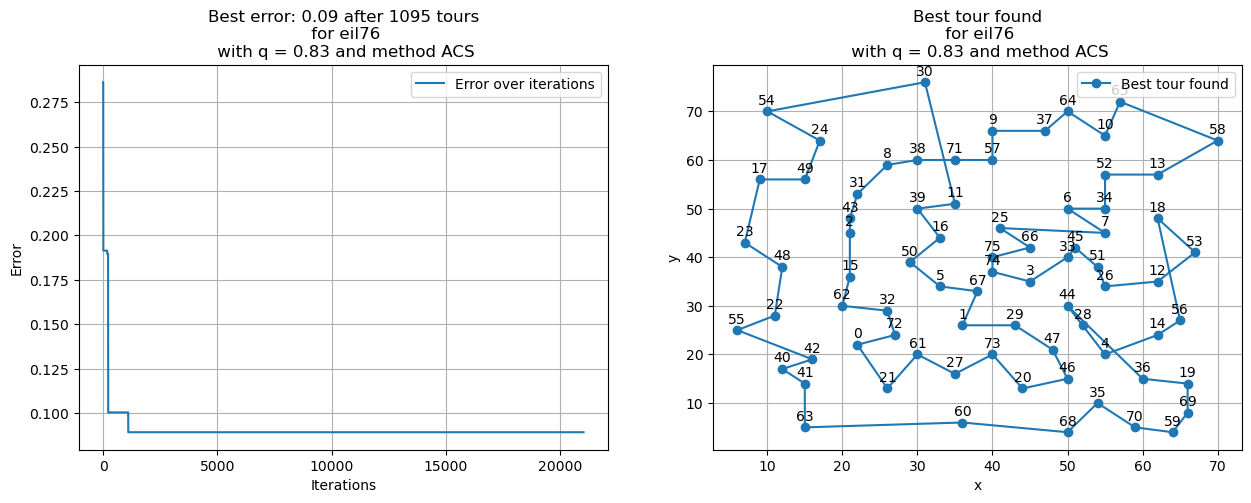

method: TWO_OPT
Best tour found: [62 22 55 40 42 41 63 21 60 20 46 35 68 70 59 69 19 36 14 56 12 53 18  7
  6 34 52 13 58 65 10 64 37  9 30 54 24 49 17 23 48 15  2 43 31  8 38 71
 57 11 39 16 50  5 67  3 74 75 25 66 45 33 51 26 44 28  4 47 29  1 73 27
 61  0 72 32]


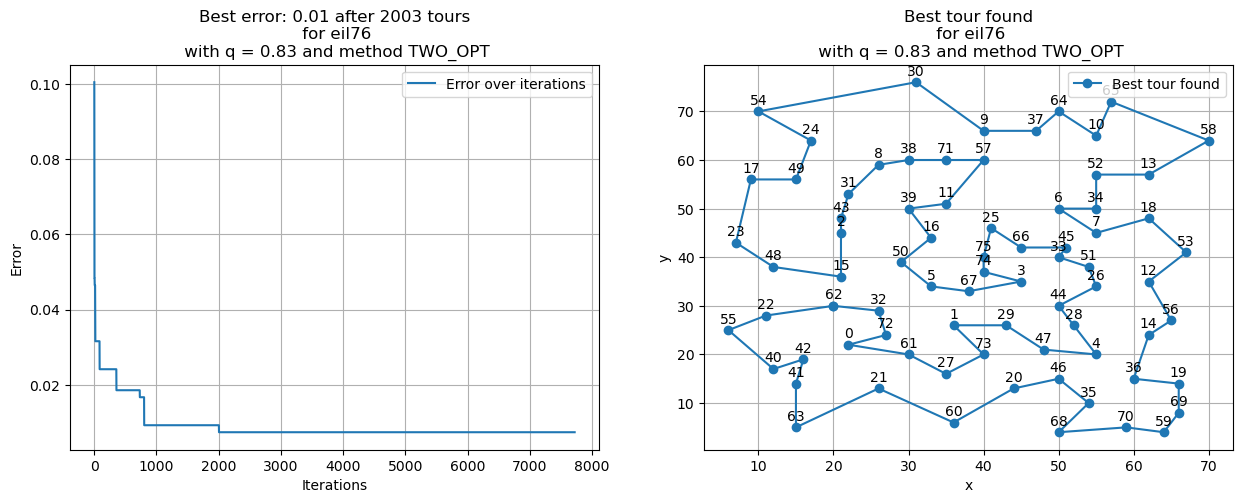

method: TWO_OPT_CL
Best tour found: [73 27 61  1 29 47  4 28 44 26 51 45 33 66 25 75 74  3 67  5 50 16 39 11
 57 71 38  8 31 43  2 15 62 32 72  0 21 63 41 42 40 55 22 48 23 17 49 24
 54 30  9 37 64 65 10 58 13 52  6 34  7 18 53 12 56 14 36 19 69 59 70 68
 35 46 20 60]


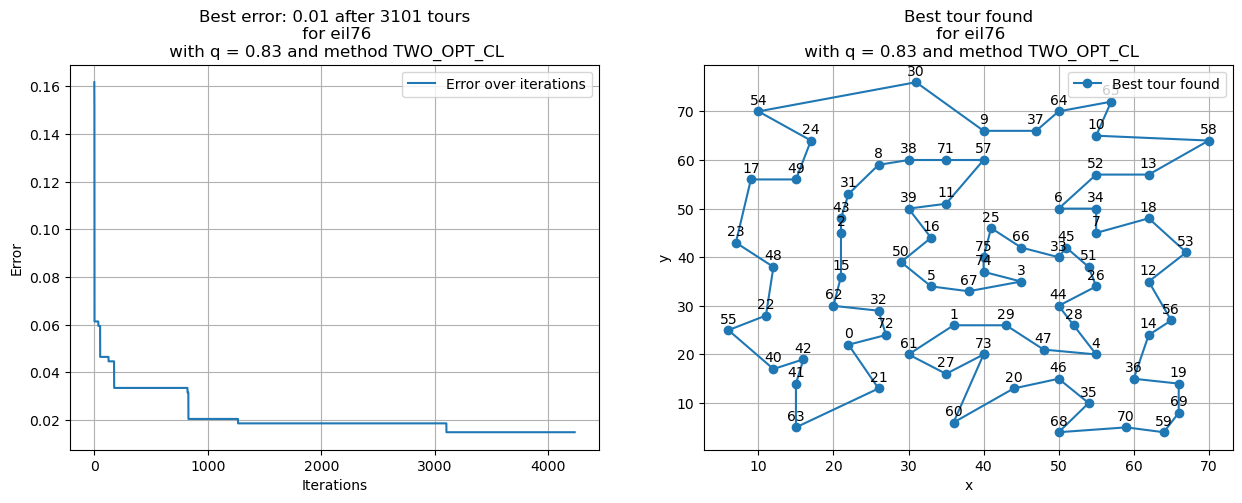

+------------+---------------------------+-------------+-------------+------------+---------+------------+
| eil76 0.83 | Number of tours generated | Best Length | Mean Length | Std Length | Optimum | Best Error |
+------------+---------------------------+-------------+-------------+------------+---------+------------+
|    ACS     |            1095           |    586.0    |    796.35   |   63.57    |  538.0  |   8.92%    |
|  TWO_OPT   |            2003           |    542.0    |    769.29   |    59.8    |  538.0  |   0.74%    |
| TWO_OPT_CL |            3101           |    546.0    |    793.37   |    62.8    |  538.0  |   1.49%    |
+------------+---------------------------+-------------+-------------+------------+---------+------------+



In [148]:
ic = TSP_Instance_Creator("standard", 'eil76.tsp')
print(f"Instance: {ic.name}")
print()

resulting(ic, time_limit=180)

#### Comment 
The algorithm is effective, but its performance can be significantly enhanced by fine-tuning and combining it with optimization techniques. The standalone use of the Ant Colony System (`ACS`) technique may not always produce satisfactory results, as shown by the findings. However, incorporating optimization techniques such as `TWO_OPT` or `TWO_OPT_CL` leads to substantial improvements, resulting in solutions that are close to optimal.

The algorithm's performance is notably sensitive to the choice of parameters, particularly the exploration-exploitation trade-off parameter `q0`. Setting `q0 = 0.98` generally produces superior results. The synergy between the `TWO_OPT` method and `q0 = 0.98` further enhances the algorithm's performance, highlighting the importance of parameter tuning for achieving optimal results.

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### Instance ch130.tsp
- nPoints: 130
- best_sol: 6110.0

Instance: ch130

q0: 0.5

method: ACS
Best tour found: [15, 127, 61, 104, 111, 114, 27, 116, 82, 2, 113, 107, 7, 17, 45, 117, 79, 19, 3, 34, 32, 20, 21, 36, 46, 39, 22, 12, 66, 95, 9, 13, 121, 54, 43, 41, 52, 119, 59, 50, 57, 48, 71, 90, 72, 98, 73, 51, 74, 64, 55, 102, 37, 11, 86, 78, 94, 14, 28, 23, 33, 16, 30, 26, 99, 18, 42, 103, 106, 126, 69, 25, 96, 93, 88, 109, 97, 47, 24, 67, 62, 81, 56, 8, 100, 110, 122, 118, 35, 83, 31, 112, 76, 80, 91, 105, 101, 5, 92, 65, 89, 124, 84, 58, 29, 125, 120, 77, 70, 38, 40, 0, 129, 49, 1, 53, 115, 6, 87, 68, 63, 85, 123, 128, 60, 4, 10, 75, 44, 108]


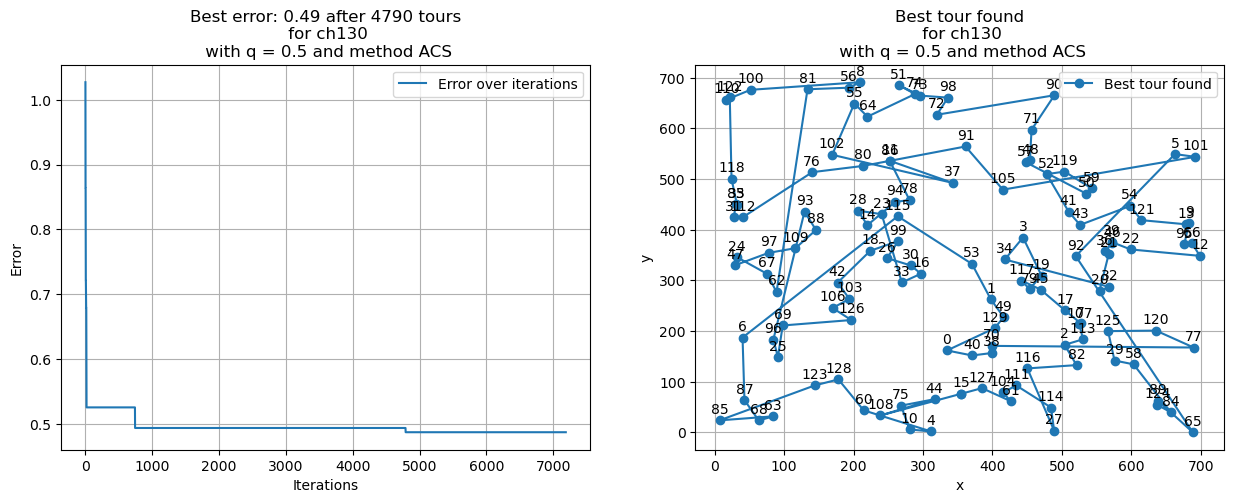

method: TWO_OPT
Best tour found: [ 39  46  21  36  92  19  45  79 117   1  49 129  70  38  40   0 126 106
 103  42 109  88  93  76 102  80  11  86  37  78  94 115  23  28  14  99
  18  26  30  33  16  53  34   3  43  41  50  59 119  52 105  57  48  71
  90  91  72  98  73  74  51  64  55   8  56  81 100 122 110 118  83  35
  31 112  24  47  97  67  62  69  96   6  25  87  85  68  63 123 128  60
 108  10   4  75  44  15 127 104  61 111 116 114  27  65  84 124  89  58
  77 120 125  29  82   2 113 107   7  17  20  32  12  66  95  13   9 101
   5  54 121  22]


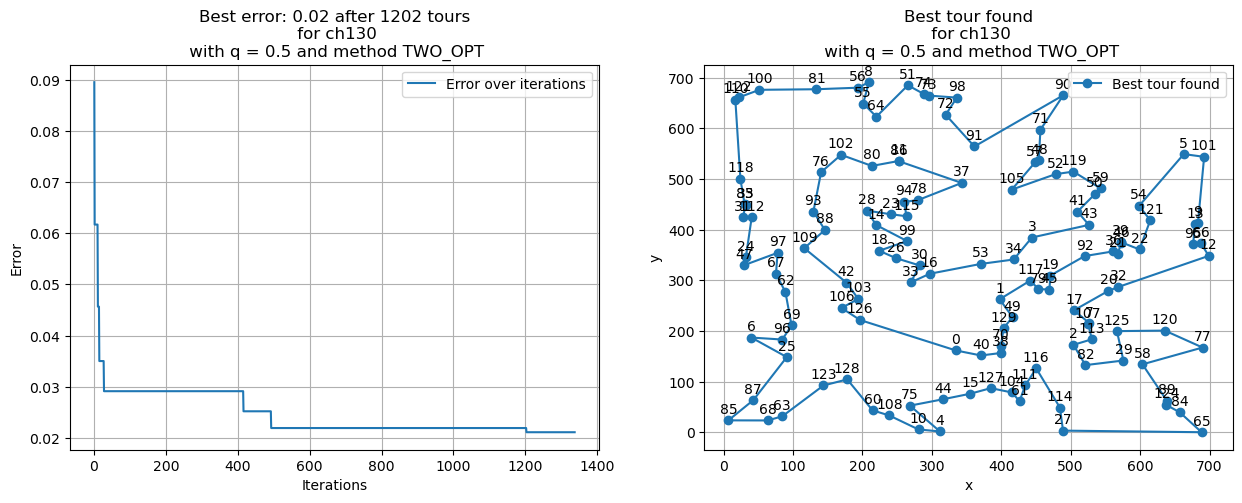

method: TWO_OPT_CL
Best tour found: [ 99  26  42 103 126 106  69  96   6  25  87  85  63  68 123 128  60 108
  75  10   4  44  15 127  61 104 111 116 114  27  65  84 124  89  77 120
  58  29  82   2 113 125 107   7  17  20  32  19  45  79 117  53  34   3
  92  43  41  52 119  59  50  54 121  46  39  36  21  22  12  66  95  13
   9 101   5  90  71  48  57 105  37  91  72  98  73  74  51  64  55   8
  56  81 100 122 110 118  83  35  31 112  24  47  62  67  97 109  88  93
  76 102  80  11  86  78  94 115  23  28  14  18  30  16   0  40  38  70
 129  49   1  33]


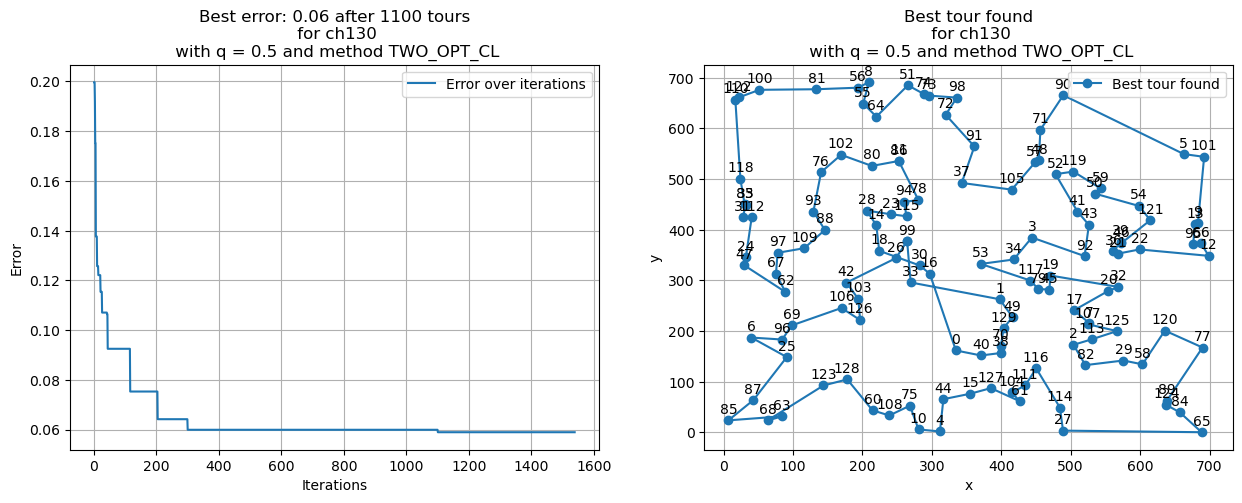

+------------+---------------------------+-------------+-------------+------------+---------+------------+
| ch130 0.5  | Number of tours generated | Best Length | Mean Length | Std Length | Optimum | Best Error |
+------------+---------------------------+-------------+-------------+------------+---------+------------+
|    ACS     |            4790           |    9087.0   |   12855.49  |  1079.27   |  6110.0 |   48.72%   |
|  TWO_OPT   |            1202           |    6239.0   |   12109.09  |   1029.8   |  6110.0 |   2.11%    |
| TWO_OPT_CL |            1100           |    6470.0   |   12490.53  |  1063.58   |  6110.0 |   5.89%    |
+------------+---------------------------+-------------+-------------+------------+---------+------------+

q0: 0.98

method: ACS
Best tour found: [11, 86, 80, 102, 76, 93, 88, 109, 97, 24, 47, 67, 62, 69, 25, 96, 6, 87, 85, 68, 63, 123, 128, 60, 108, 75, 10, 4, 44, 15, 127, 104, 61, 111, 116, 38, 70, 40, 0, 129, 49, 1, 117, 79, 45, 19, 3, 34, 53, 16, 30, 

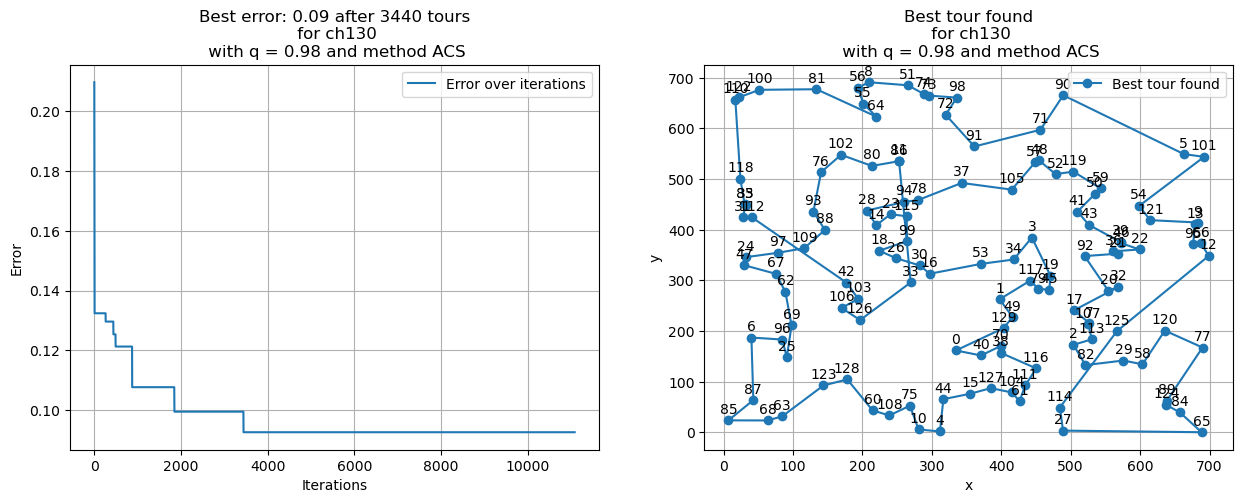

method: TWO_OPT
Best tour found: [ 68  85  87  25   6  96  69  62  67  47  24  97 109  88  28  14  23 115
  94  78  86  11  80 102  76  93 112  31  35  83 118 110 122 100  81  56
   8  55  64  51  74  73  98  72  91  37 105  57  48  52 119  71  90   5
 101   9  13  66  12  95  22  21  36  46  39 121  54  59  50  41  43   3
  34  53  16  33  30  99  26  18  42 103 106 126   0  40  38  70 129  49
   1 117  79  45  19  92  32  20  17 107   7 125 113   2  82  29  58 120
  77  89 124  84  65  27 114 116 111  61 104 127  15  44   4  10  75 108
  60 128 123  63]


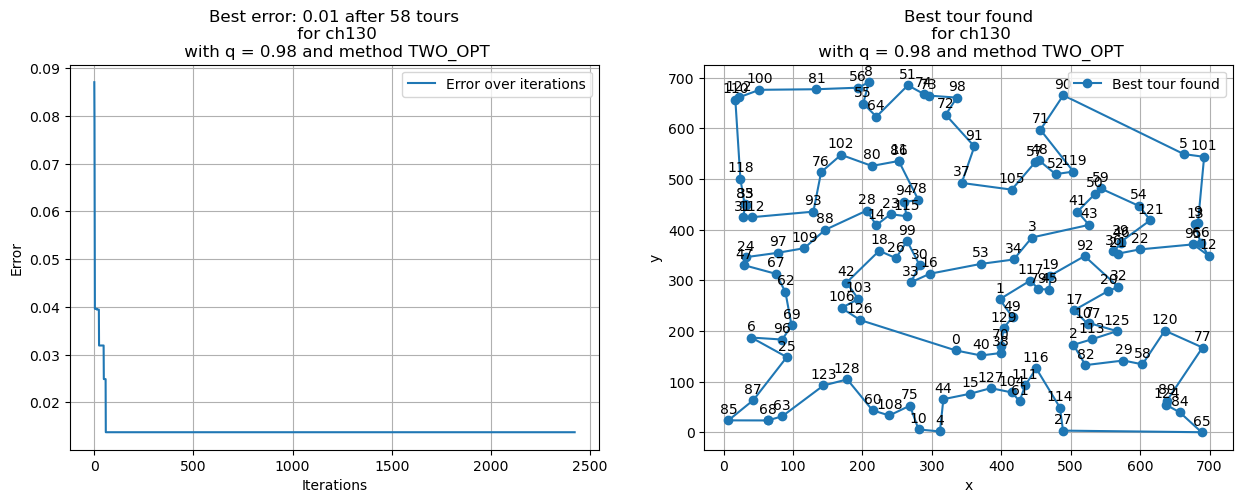

method: TWO_OPT_CL
Best tour found: [  9  13  66  95  12  22  46  39  21  36  92  43  41  50  59 119  52  48
  57 105  37  78  94  11  86  80 102  76  93 109  88  28  14  23 115  99
  26  18  42 103 106 126  33  30  16  53  34   3  19  32  20 125  29  58
 120  77  89 124  84  65  27 114  82   2 113 107   7  17  45  79 117   1
  49 129   0  40  70  38 116 111  61 104 127  15  44   4  10  75 108  60
 128 123  63  68  85  87  25   6  96  69  62  67  47  24  97 112  31  35
  83 118 110 122 100  81  56   8  55  64  51  74  73  98  72  91  71  90
   5 101  54 121]


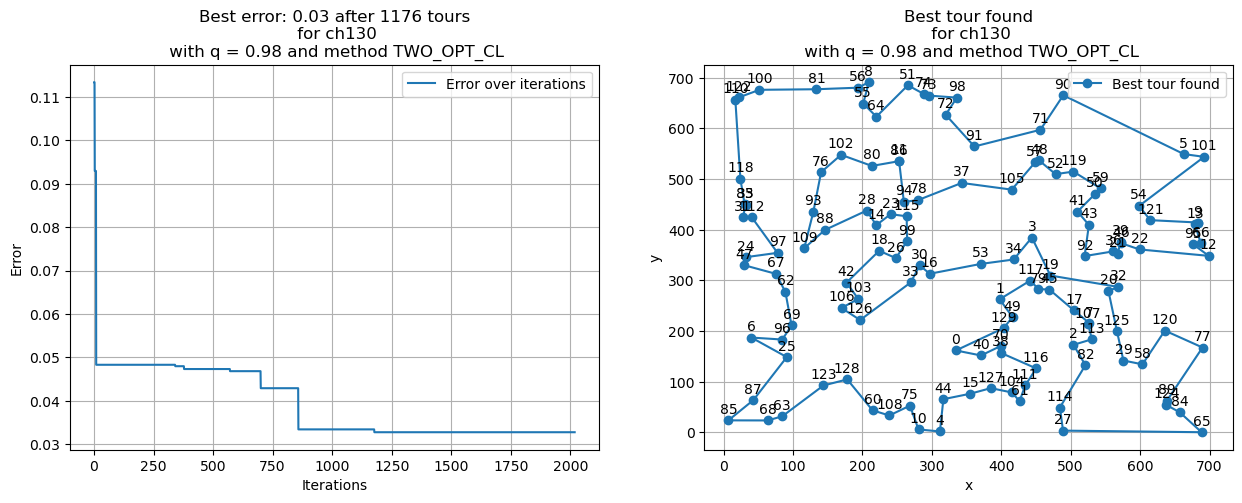

+------------+---------------------------+-------------+-------------+------------+---------+------------+
| ch130 0.98 | Number of tours generated | Best Length | Mean Length | Std Length | Optimum | Best Error |
+------------+---------------------------+-------------+-------------+------------+---------+------------+
|    ACS     |            3440           |    6676.0   |   8057.19   |   474.48   |  6110.0 |   9.26%    |
|  TWO_OPT   |             58            |    6194.0   |   7841.53   |   426.52   |  6110.0 |   1.37%    |
| TWO_OPT_CL |            1176           |    6310.0   |   8068.26   |   479.15   |  6110.0 |   3.27%    |
+------------+---------------------------+-------------+-------------+------------+---------+------------+

q0: 0.9

method: ACS
Best tour found: [11, 86, 80, 102, 76, 93, 88, 109, 97, 67, 62, 69, 96, 25, 6, 87, 68, 63, 85, 123, 128, 60, 108, 75, 10, 4, 44, 15, 0, 40, 38, 70, 129, 49, 1, 117, 19, 45, 79, 17, 107, 7, 113, 2, 82, 29, 58, 120, 77, 89, 124, 84

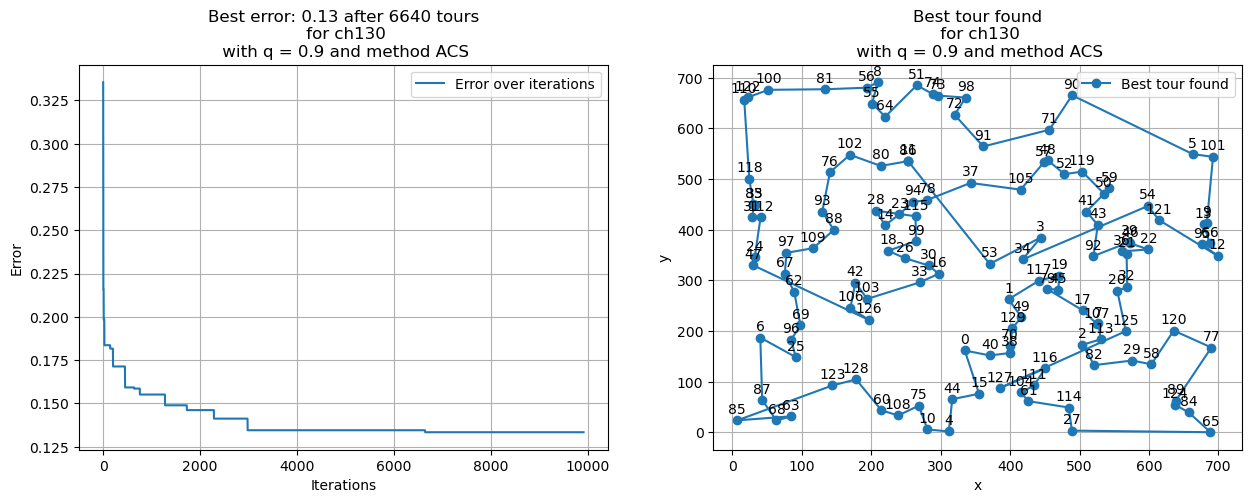

method: TWO_OPT
Best tour found: [ 52  48  57 105   3  34  53  16  33  30  99  26  18  14  28  23 115  94
  78  37  11  86  80 102  76  93  88 109  42 103 106 126   0  40  38  70
 129  49   1 117  79  45  19  92  36  39  46  22  21  32  20  17 107   7
 125 113   2  82  29  58 120  77  89 124  84  65  27 114 116 111  61 104
 127  15  44   4  10  75 108  60 128 123  63  68  85  87  25   6  96  69
  62  67  97  47  24 112  31  35  83 118 110 122 100  81  56   8  55  64
  51  74  73  98  72  91  71  90   5 101   9  13  66  12  95 121  54  43
  41  50  59 119]


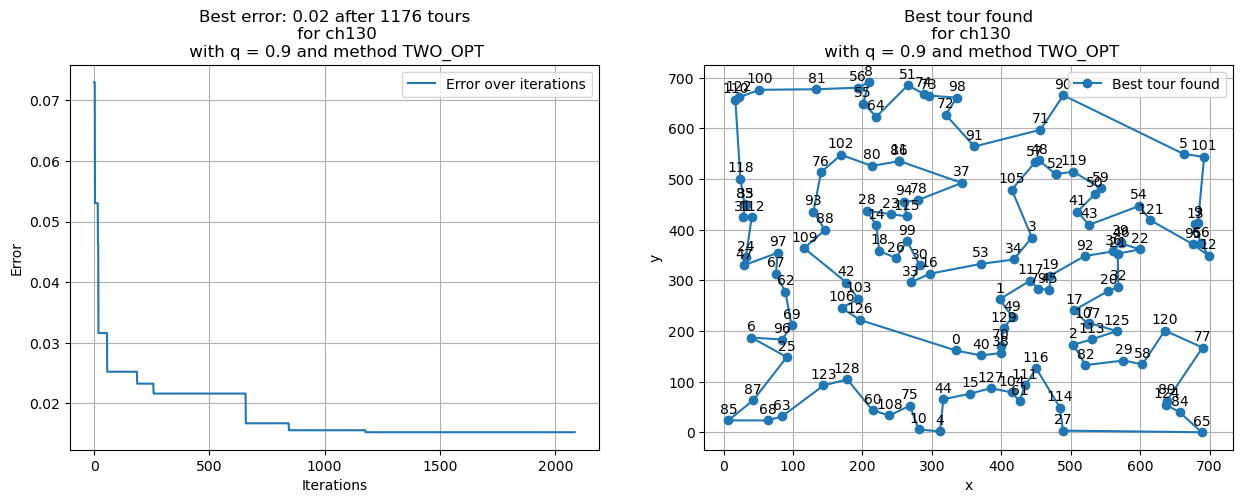

method: TWO_OPT_CL
Best tour found: [100  81  56   8  55  64  51  74  73  98  72  91  90  71  48  57  52 119
  59  50  41  43 121  54   5 101  13   9  66  12  95  22  46  39  21  36
  92  32  20  17   7 107 113   2  82  29  58 125 120  77  89 124  84  65
  27 114  61 104 111 116 127  15  44   4  10  75 108  60 128 123  63  68
  85  87  25  96   6  69  62  67  47  24  97 109  88  28  14  23  94  78
 115  99  26  18  42 106 126 103  33  30  16  53  34 117   1   0  40  38
  70 129  49  79  45  19   3 105  37  86  11  80 102  76  93 112  31  35
  83 118 110 122]


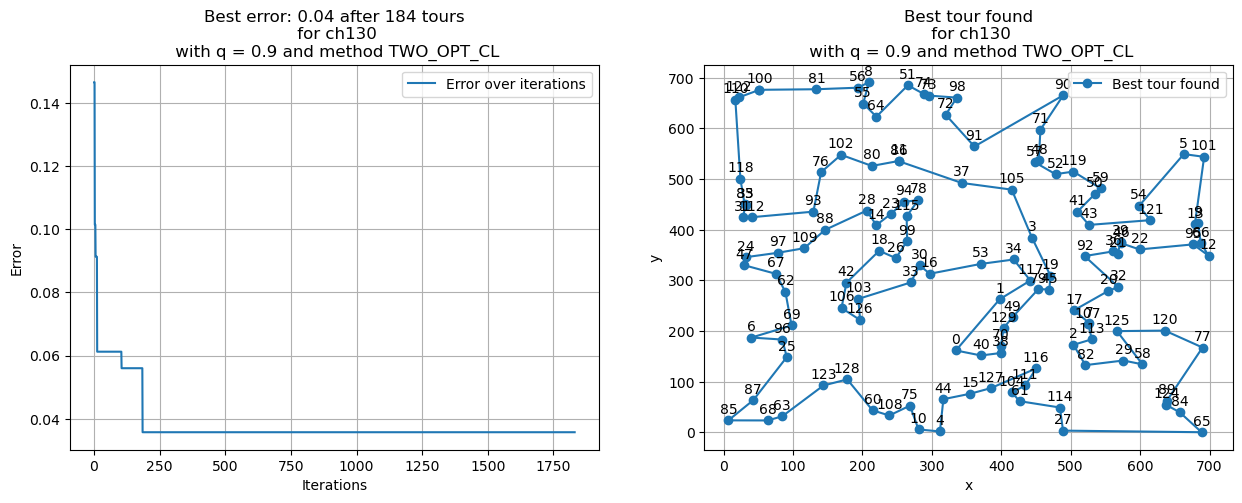

+------------+---------------------------+-------------+-------------+------------+---------+------------+
| ch130 0.9  | Number of tours generated | Best Length | Mean Length | Std Length | Optimum | Best Error |
+------------+---------------------------+-------------+-------------+------------+---------+------------+
|    ACS     |            6640           |    6925.0   |   8889.19   |   651.04   |  6110.0 |   13.34%   |
|  TWO_OPT   |            1176           |    6203.0   |   8572.38   |   606.09   |  6110.0 |   1.52%    |
| TWO_OPT_CL |            184            |    6328.0   |   8873.35   |   655.05   |  6110.0 |   3.57%    |
+------------+---------------------------+-------------+-------------+------------+---------+------------+



In [153]:
ic = TSP_Instance_Creator("standard", 'ch130.tsp')
print(f"Instance: {ic.name}")
print()

resulting(ic, time_limit=180)

#### Comment 
As I already said before, although the algorithm is effective on its own, it can be further improved by adjusting parameters and integrating optimization techniques. Depending solely on the Ant Colony System (`ACS`) technique may not consistently yield satisfactory results, as evidenced by the findings. The algorithm's performance improves significantly when optimization methods like `TWO_OPT` or `TWO_OPT_CL` are used, resulting in solutions that approach optimality.

It is important to note that the algorithm's responsiveness to parameter settings, particularly the exploration-exploitation trade-off parameter `q0`, is crucial for achieving optimal results. Setting `q0` to `0.98` consistently produces optimal results. Combining the `TWO_OPT` method with `q0 = 0.98` improves the algorithm's effectiveness. This highlights the importance of fine-tuning parameters to achieve superior performance.

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### Instance d198.tsp
- nPoints: 198
- best_sol: 15780.0

Instance: d198

q0: 0.5

method: ACS
Best tour found: [11, 10, 9, 8, 7, 12, 40, 39, 99, 85, 84, 72, 69, 66, 59, 58, 54, 43, 55, 67, 71, 83, 86, 98, 60, 65, 97, 73, 82, 81, 87, 96, 88, 89, 95, 94, 93, 92, 101, 51, 45, 53, 44, 37, 30, 31, 36, 35, 32, 33, 17, 18, 19, 22, 21, 23, 20, 24, 25, 26, 46, 38, 34, 52, 61, 74, 64, 80, 75, 76, 77, 63, 49, 47, 48, 50, 62, 110, 111, 106, 112, 105, 122, 119, 118, 117, 108, 107, 109, 113, 104, 103, 102, 116, 115, 114, 121, 120, 138, 155, 154, 153, 157, 156, 158, 159, 160, 161, 151, 148, 147, 146, 140, 139, 134, 132, 131, 130, 129, 128, 126, 169, 127, 136, 135, 143, 144, 142, 141, 133, 125, 124, 168, 123, 137, 145, 152, 149, 150, 162, 163, 164, 165, 171, 170, 181, 180, 176, 174, 175, 172, 173, 177, 184, 183, 179, 178, 193, 182, 187, 188, 189, 190, 191, 186, 185, 192, 195, 196, 197, 194, 16, 15, 14, 13, 57, 56, 41, 42, 68, 70, 29, 28, 27, 79, 78, 91, 90, 100, 166, 167, 5, 6, 4, 3, 2, 1, 0]


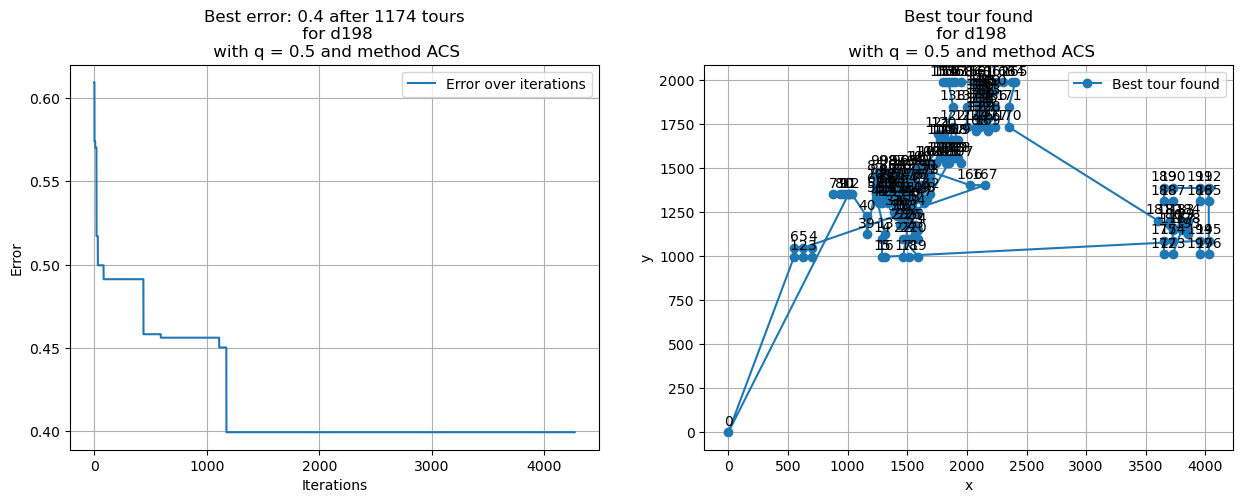

method: TWO_OPT
Best tour found: [158 137 123 168 124 125 129 130 131 133 132 134 140 139 141 142 145 146
 147 159 160 161 152 151 148 144 149 150 162 163 164 165 171 136 143 135
 128 126 169 127 170 188 189 190 187 183 179 184 186 191 192 185 195 196
 197 194 193 178 177 174 173 172 175 176 180 182 181 167 166 107 108 109
 110 106 105 111 112 113 104  91  90  79  78  62  48  47  34  38  46  51
  50  49  63  77  76  75  80  64  61  52  45  35  36  37  30  31  28  29
  27  32  33  26  25  24  20  23  21  22  19  18  17  16  15  14  13  40
  39   3   2   0   1   6   5   4   7   8   9  10  11  12  85  99  84  70
  68  57  56  41  42  55  58  67  71  98  86  83  72  69  66  59  54  43
  44  53  60  65  73  82  87  97  96  81  74  88  89  95  94  93  92 100
 101 102 103 121 120 114 115 116 117 118 119 122 138 153 154 155 156 157]


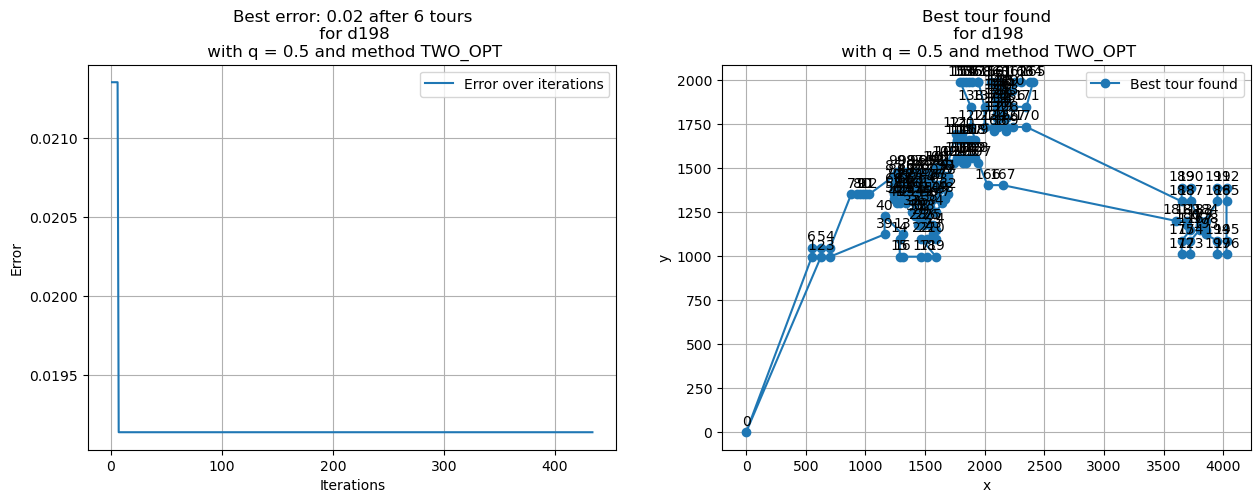

method: TWO_OPT_CL
Best tour found: [167 166 107 108 109 110 106 105  91  90  79  78  62  49  47  48  34  46
  38  32  33  25  26  27  22  21  23  24  20  19  18  17  16  15  14   0
   5   6   1   2   3   4   7   8   9  10  11  12  40  39  13  28  29  35
  36  31  30  37  44  43  54  59  66  69  72  83  71  67  58  55  42  41
  56  57  68  70  85  84  99  98  86  97  96  87  82  81  73  65  60  53
  52  45  51  50  63  77  76  75  80  64  61  74  88  89  95  94 100  93
  92 101 102 103 104 113 112 111 116 115 114 121 120 117 118 119 122 138
 155 153 154 156 157 158 137 123 168 124 125 169 126 128 136 143 144 145
 142 140 135 134 132 129 130 131 133 139 141 146 147 148 152 159 160 161
 151 149 150 162 163 164 165 171 127 170 188 190 189 187 183 179 184 186
 191 192 185 194 195 196 197 193 178 177 176 174 173 172 175 180 182 181]


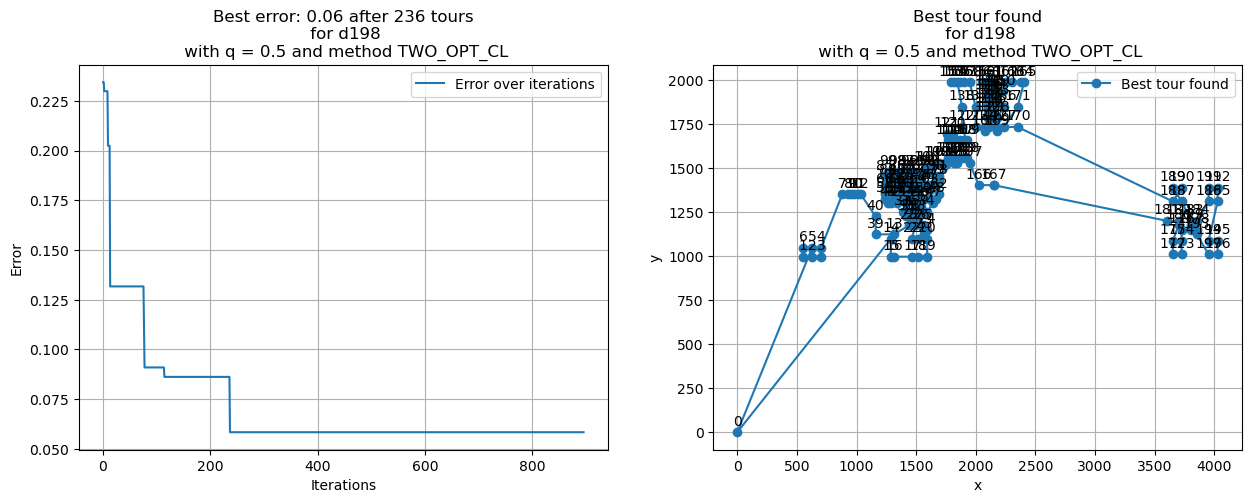

+------------+---------------------------+-------------+-------------+------------+---------+------------+
|  d198 0.5  | Number of tours generated | Best Length | Mean Length | Std Length | Optimum | Best Error |
+------------+---------------------------+-------------+-------------+------------+---------+------------+
|    ACS     |            1174           |   22080.0   |   30198.3   |  2696.29   | 15780.0 |   39.92%   |
|  TWO_OPT   |             6             |   16082.0   |   29053.1   |  2600.65   | 15780.0 |   1.91%    |
| TWO_OPT_CL |            236            |   16701.0   |   29580.4   |   2656.5   | 15780.0 |   5.84%    |
+------------+---------------------------+-------------+-------------+------------+---------+------------+

q0: 0.98

method: ACS
Best tour found: [145, 142, 141, 139, 133, 134, 132, 130, 129, 128, 126, 169, 127, 136, 143, 144, 148, 147, 146, 152, 151, 161, 160, 159, 158, 157, 156, 155, 154, 153, 138, 137, 131, 135, 140, 149, 150, 162, 163, 164, 165, 171, 

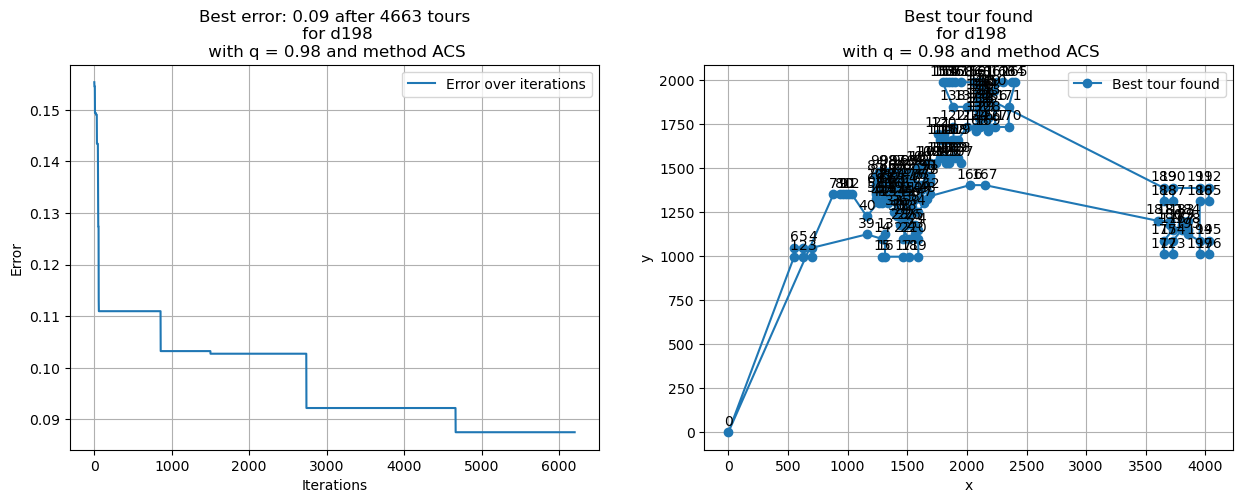

method: TWO_OPT
Best tour found: [ 69  65  60  53  44  37  30  31  36  35  32  33  38  46  50  49  63  77
  76  75  64  51  45  52  61  74  81  73  82  87  97  96  88  89  95  80
  94  93 100  92 101 102 103 114 115 121 120 116 117 118 119 122 123 168
 124 125 128 126 169 127 170 171 136 135 134 132 129 130 131 133 139 140
 142 145 146 141 137 138 153 154 155 156 157 158 159 160 161 151 152 147
 148 144 143 149 150 162 163 164 165 189 188 187 190 191 192 185 186 194
 195 196 197 193 178 184 183 179 177 173 172 175 174 176 180 182 181 167
 166 107 108 109 110 106 105 111 112 113 104  91  90  79  78  62  48  47
  34  24  25  26  27  29  28  22  21  23  20  19  18  17  16  15  14  13
  39   0   1   6   5   2   3   4   7   8   9  10  11  12  40  41  56  57
  68  70  84  85  99  98  86  83  72  71  67  58  55  42  43  54  59  66]


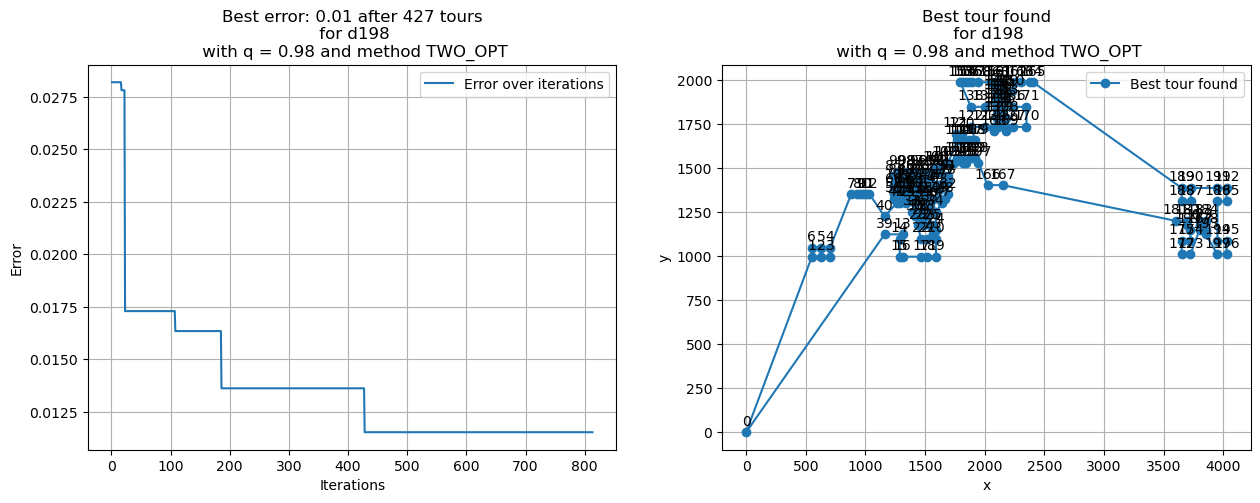

method: TWO_OPT_CL
Best tour found: [167 166 107 108 109 110 106 105 111 112 113 104  91  78  62  48  47  49
  50  46  38  34  25  24  20  19  18  17  16  15  13  14  39   0   1   6
   5   2   3   4   7   8   9  10  11  12  40  42  41  56  57  68  70  84
  85  99  98  86  83  71  72  69  66  59  67  58  55  54  43  37  44  53
  60  65  73  81  82  87  97  96  88  74  61  52  35  36  30  31  29  28
  22  21  23  26  27  32  33  45  51  64  75  76  63  77  80  89  95 101
 100  94  93  92  79  90 102 103 114 115 121 120 116 117 118 119 122 123
 168 124 125 130 131 132 129 128 126 169 127 136 143 140 135 134 133 139
 137 138 153 154 155 156 157 158 159 152 160 161 151 148 147 146 141 142
 145 144 149 150 162 163 164 165 171 170 189 188 182 180 176 175 172 173
 174 177 179 183 184 178 193 197 196 195 194 186 185 192 191 190 187 181]


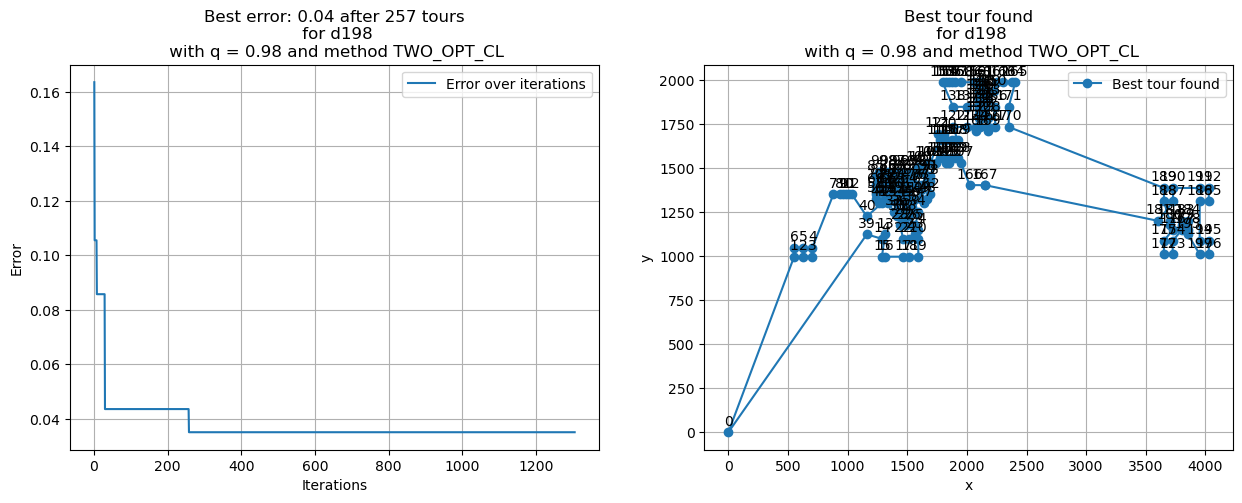

+------------+---------------------------+-------------+-------------+------------+---------+------------+
| d198 0.98  | Number of tours generated | Best Length | Mean Length | Std Length | Optimum | Best Error |
+------------+---------------------------+-------------+-------------+------------+---------+------------+
|    ACS     |            4663           |   17161.0   |   19694.89  |  1133.56   | 15780.0 |   8.75%    |
|  TWO_OPT   |            427            |   15962.0   |   19825.19  |  1073.07   | 15780.0 |   1.15%    |
| TWO_OPT_CL |            257            |   16334.0   |   19820.58  |  1122.24   | 15780.0 |   3.51%    |
+------------+---------------------------+-------------+-------------+------------+---------+------------+

q0: 0.93

method: ACS
Best tour found: [143, 136, 135, 134, 133, 139, 131, 130, 129, 125, 124, 168, 123, 119, 118, 117, 116, 115, 114, 121, 120, 122, 138, 154, 153, 155, 156, 157, 158, 159, 160, 152, 148, 145, 144, 149, 150, 162, 163, 164, 165, 171, 

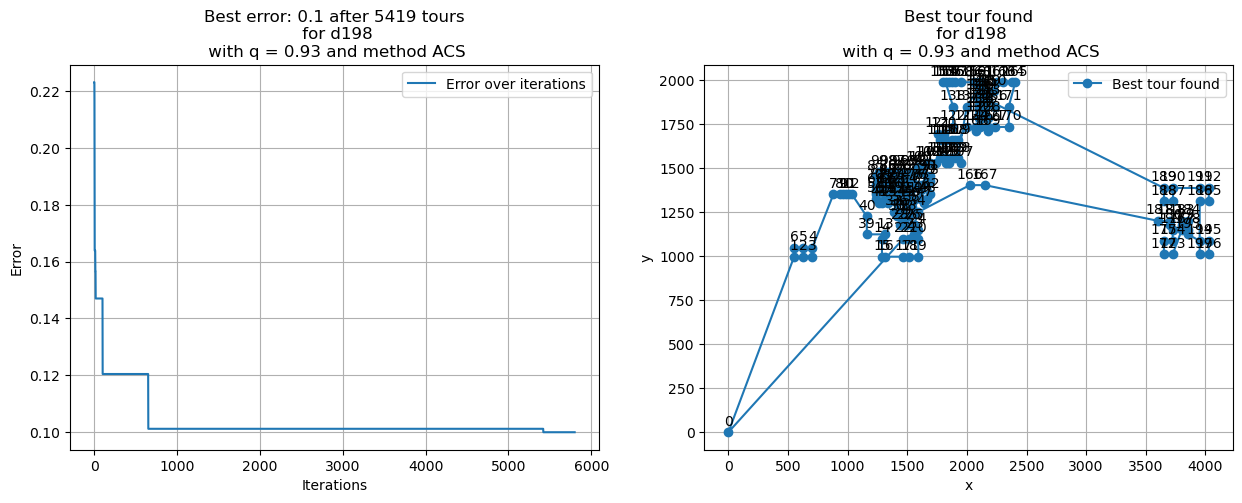

method: TWO_OPT
Best tour found: [119 122 123 168 124 125 169 126 127 128 129 130 131 133 132 134 135 136
 143 144 145 148 147 146 141 142 140 139 137 138 153 154 155 156 157 158
 159 152 160 161 151 149 150 162 163 164 165 171 170 189 188 187 190 191
 192 185 186 195 196 197 194 193 178 184 183 179 177 176 174 173 172 175
 180 182 181 167 166 107 108 109 110 106 105 111 112 113 104  91  90  79
  78  62  48  47  49  34  24  20  19  18  17  16  15   0   1   6   5   2
   3   4   7   8   9  10  11  12  40  39  14  13  22  21  23  25  26  27
  29  28  30  31  36  35  32  33  38  46  50  63  77  76  75  80  64  51
  45  52  61  74  81  73  65  60  53  44  37  43  54  55  42  41  56  57
  68  70  84  85  99  98  86  83  71  67  58  59  66  72  69  82  87  97
  96  88  89  95  94  93  92 100 101 102 103 114 115 121 120 116 117 118]


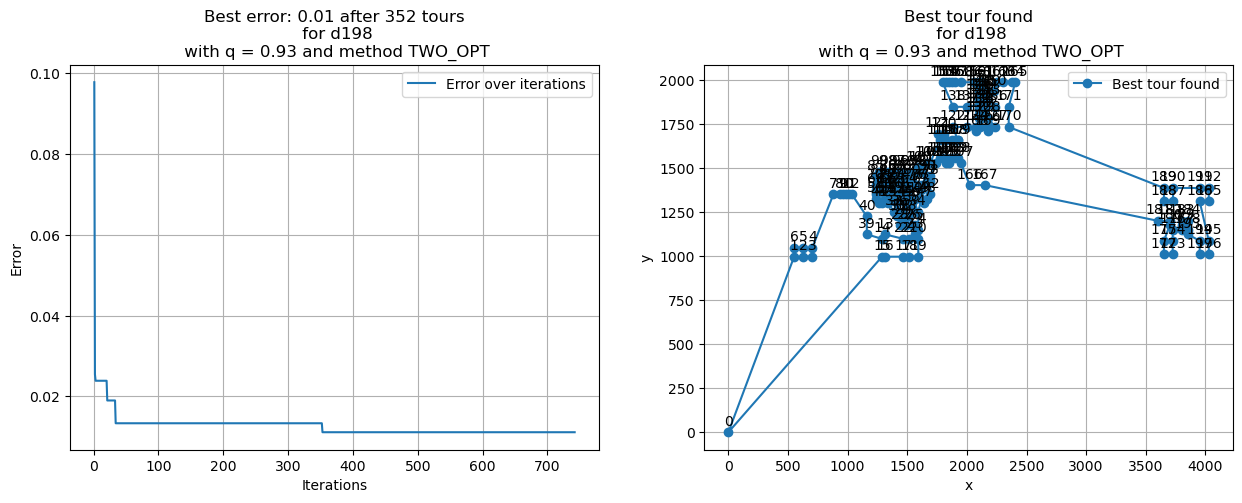

method: TWO_OPT_CL
Best tour found: [110 109 108 107 106 105 111 112 113 104  91  90  79  78  62  48  47  49
  50  34  38  46  45  35  32  33  25  24  23  20  19  18  17  22  21  26
  27  29  28  31  36  30  37  43  54  55  42  41  56  57  40  39  14  13
  16  15   0   1   6   5   2   3   4   7   8   9  10  11  12  68  70  84
  85  99  98  86  83  72  71  67  58  59  66  69  87  97  96  88  89  74
  81  82  73  65  60  53  44  52  61  51  64  75  76  63  77  80  95  94
  93  92 100 101 102 103 114 121 120 115 116 122 117 118 119 123 168 124
 125 130 131 133 139 137 138 153 154 155 156 157 158 159 152 160 161 151
 148 147 146 141 140 135 134 132 129 128 126 169 127 136 143 142 145 144
 149 150 162 163 164 165 171 170 188 189 190 187 191 192 185 186 194 195
 196 197 193 178 184 183 179 177 182 180 176 174 173 172 175 181 167 166]


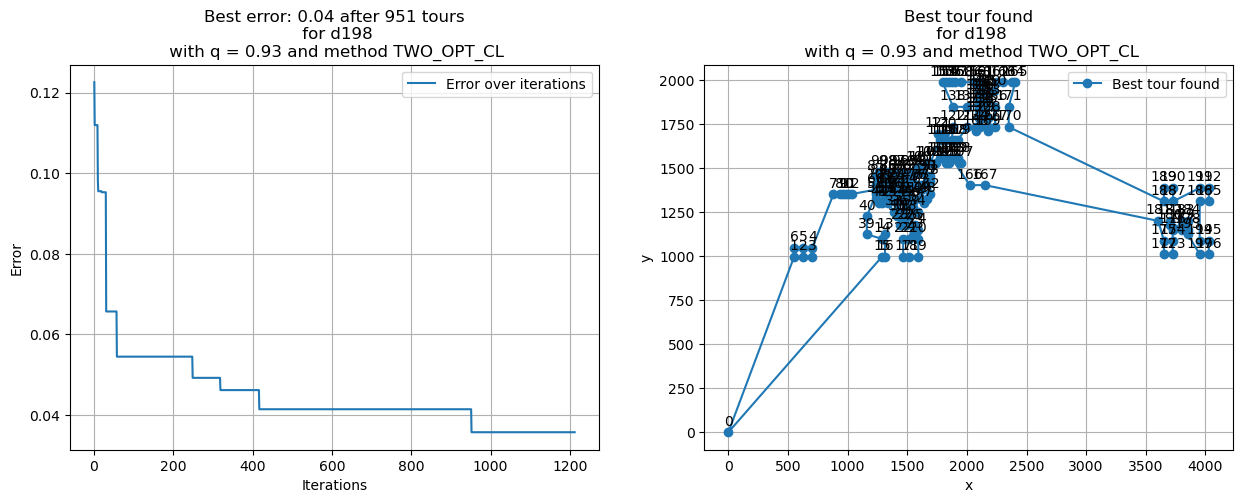

+------------+---------------------------+-------------+-------------+------------+---------+------------+
| d198 0.93  | Number of tours generated | Best Length | Mean Length | Std Length | Optimum | Best Error |
+------------+---------------------------+-------------+-------------+------------+---------+------------+
|    ACS     |            5419           |   17358.0   |   20889.97  |  1424.32   | 15780.0 |   10.00%   |
|  TWO_OPT   |            352            |   15956.0   |   20800.06  |  1288.84   | 15780.0 |   1.12%    |
| TWO_OPT_CL |            951            |   16343.0   |   20941.11  |  1393.21   | 15780.0 |   3.57%    |
+------------+---------------------------+-------------+-------------+------------+---------+------------+



In [154]:
ic = TSP_Instance_Creator("standard", 'd198.tsp')
print(f"Instance: {ic.name}")
print()

resulting(ic, time_limit=180)

#### Comment 
The algorithm is effective on its own, however it can be further improved through careful parameter tuning and the integration of optimization techniques. Using the Ant Colony System (`ACS`) technique alone may not meet expectations, as demonstrated by the findings. However, by implementing optimization methods like `TWO_OPT` or `TWO_OPT_CL`, the algorithm's performance can be significantly improved, resulting in solutions that are close to optimal.
This is true even for the most difficult instances like `d198`, where the algorithm's performance benefits greatly from the precise selection of parameters and the integration of optimization techniques.

The algorithm's responsiveness to parameter choices, particularly the exploration-exploitation trade-off parameter `q0`, highlights the importance of careful tuning. Optimal outcomes are consistently achieved with `q0` set to `0.98`. Pairing the `TWO_OPT` method with `q0 = 0.98` further enhances the algorithm's effectiveness, emphasizing the critical role of parameter fine-tuning in achieving superior performance.

In conclusion, the algorithm's effectiveness is not only due to its inherent capabilities but also to the strategic combination of techniques and parameter optimization. The algorithm consistently produces good results for the given problem across various instances, showcasing its reliability. Its adaptability is demonstrated through the use of optimization techniques (`TWO_OPT` and `TWO_OPT_CL`) and setting parameter, such as `q0`.

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
acs = ACS(ic)

print('tau0 =', acs.tau0)
for j in acs.candidate_list.keys():
  print()
  print("node          :", j)
  print("candidate list:", acs.candidate_list[j][:3])
  print("eta values    :", acs.eta[j][:3])
  print("pheromone     :", acs.pheromone[j][:3])
  if j>2:
    break


# test twoOpt_with_cl

the implementation of 2opt with the candidate list has worst performances in term of quality but achieves improvements using fewer computation

In [ ]:
from time import time
from AI_USI_MA.solvers.two_opt_with_candidate import twoOpt_with_cl

ic = TSP_Instance_Creator("standard", 'fl1577.tsp')

initial_sol, initial_len = nn(ic.dist_matrix, starting_node=np.random.choice(ic.nPoints))
acs = ACS(ic)

In [ ]:
start = time()
tour, len_new = twoOpt_with_cl(initial_sol, initial_len, ic.dist_matrix, acs.candidate_list)
print(f' 2opt with candidate: initial len {initial_len}, final len {len_new} \n execution time: {time() - start}')

start = time()
tour, len_new = twoOpt(initial_sol, initial_len, ic.dist_matrix)
print(f' 2opt: initial len {initial_len}, final len {len_new} \n execution time: {time() - start}')

In [ ]:
list_time = []
for _ in range(5):
  initial_sol, initial_len = nn(ic.dist_matrix, starting_node=np.random.choice(ic.nPoints))
  start = time()
  _ = twoOpt_with_cl(initial_sol, initial_len, ic.dist_matrix, acs.candidate_list)
  list_time.append(time()- start)

print(f"mean {np.mean(list_time)},  std {np.std(list_time)}" )

In [ ]:
list_time = []
for _ in range(5):
  initial_sol, initial_len = nn(ic.dist_matrix, starting_node=np.random.choice(ic.nPoints))
  start = time()
  _ = twoOpt(initial_sol, initial_len, ic.dist_matrix)
  list_time.append(time() - start)

print(f"mean {np.mean(list_time)},  std {np.std(list_time)}" )